# Comparación de los pares binarios de Allen et al. con los de GAIA DR2

In [1]:
%matplotlib nbagg

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inp
import scipy.stats as stats

#Mostrar la tabla completa
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

def del_ra(x,y):
    a = np.abs(x-y)
    b = np.abs(a-360.0)
    return np.minimum(a,b)

def pm2kms(pm,dist):
    """Proper motions in mas/yr to km/s, using distance in pc"""
    return (np.pi/(180*3600*1000))*(1./(365*24*3600))*(3.086E13)*pm*dist
def pm2kms_error(pm,pm_err,dist,dist_err):
    """Proper motions error in mas/yr to km/s, using distance in pc"""
    return pm2kms(pm,dist)*(pm_err/pm + dist_err/dist)

def vel_tan_diff(pmra_1,pmdec_1,dist_1,pmra_2,pmdec_2,dist_2):
    """Tangential velocity difference using pm in ra and dec directions, and distances in pc,
    in km/s
    Only valid for small angles.
    """
    return np.sqrt((pm2kms(pmra_2,dist_2)-pm2kms(pmra_1,dist_1))**2 +
                   (pm2kms(pmdec_2,dist_2)-pm2kms(pmdec_1,dist_1))**2)

def vel_tan_diff_err(pmra_1,pmra_1_err,pmdec_1,pmdec_1_err,dist_1,dist_1_err,
                     pmra_2,pmra_2_err,pmdec_2,pmdec_2_err,dist_2,dist_2_err):
    """Tangential velocity difference error using pm in ra and dec directions, and distances in pc,
    in km/s
    Only valid for small angles
    """
    diffvra  = np.abs((pm2kms(pmra_2,dist_2)-pm2kms(pmra_1,dist_1))*
                      (pm2kms_error(pmra_1,pmra_1_err,dist_1,dist_1_err)+pm2kms_error(pmra_2,pmra_2_err,dist_2,dist_2_err)))
    diffvdec = np.abs((pm2kms(pmdec_2,dist_2)-pm2kms(pmdec_1,dist_1))*
                      (pm2kms_error(pmdec_1,pmdec_1_err,dist_1,dist_1_err)+pm2kms_error(pmdec_2,pmdec_2_err,dist_2,dist_2_err)))
    return (diffvra+diffvdec)/vel_tan_diff(pmra_1,pmdec_1,dist_1,pmra_2,pmdec_2,dist_2)

def cos_distang(ra1,dec1,ra2,dec2):
    dra  = np.deg2rad(del_ra(ra1,ra2))
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    return np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(dra)

def dcd(ra1,dec1,ra2,dec2,dra1,ddec1,dra2,ddec2):
    dra    = np.abs(np.deg2rad(del_ra(ra1,ra2)))
    cd1sd2 = np.abs(np.cos(np.deg2rad(dec1))*np.sin(np.deg2rad(dec2)))
    sd1cd2 = np.abs(np.sin(np.deg2rad(dec1))*np.cos(np.deg2rad(dec2)))
    dra1   = np.deg2rad(dra1)
    dra2   = np.deg2rad(dra2)
    ddec1  = np.deg2rad(ddec1)
    ddec2  = np.deg2rad(ddec2)
    
    return cd1sd2*ddec1 + sd1cd2*ddec2 + np.cos(dra)*(
    sd1cd2*ddec1 + cd1sd2*ddec2) + np.cos(np.deg2rad(dec1))*np.cos(np.deg2rad(dec2))*np.sin(dra)*(dra1+dra2)

def R3D(r1,r2,cost):
    """
    Separación tridimensional
    """
    return np.sqrt((r2-r1)**2 + 2.*r1*r2*(1.-cost))

def dR3D(r1,r2,cost,dr1,dr2,dcost):
    """
    Error en la separación tridimensional
    """
    return (np.abs(r2-r1)*(dr1+dr2) + r2*r1*dcost + (1.-cost)*(r1*dr2 + r2*dr1))/R3D(r1,r2,cost)

################################################

def seleccion(good,sigma=3.0,par=0.16,rvel=3.):
    x = good.copy()
    return x[(np.abs(1.-x.pmRA_y/x.pmra_y) < sigma*np.abs(
                 (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) &
             (np.abs(1.-x.pmDE_y/x.pmdec_y) < sigma*np.abs(
                 (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) &
#          (np.abs(1.-x.Plx_y/x.parallax_y) < sig*np.abs(
#              (x.Plx_y/x.parallax_y)*(x.e_Plx_y/x.Plx_y+x.parallax_error_y/x.parallax_y))) &
             (np.abs(1.-x.pmRA_x/x.pmra_x) < sigma*np.abs(
                 (x.pmRA_x/x.pmra_x)*(x.e_pmRA_x/x.pmRA_x+x.pmra_error_x/x.pmra_x))) &
             (np.abs(1.-x.pmDE_x/x.pmdec_x) < sigma*np.abs(
                 (x.pmDE_x/x.pmdec_x)*(x.e_pmDE_x/x.pmDE_x+x.pmdec_error_x/x.pmdec_x))) &
#          (np.abs(1.-x.Plx_x/x.parallax_x) < sig*np.abs(
#              (x.Plx_x/x.parallax_x)*(x.e_Plx_x/x.Plx_x+x.parallax_error_x/x.parallax_x))

             (x.parallax_y > (1.-par)*x.parallax_x) &
             (x.parallax_y < (1.+par)*x.parallax_x) &

             ((np.abs(x.radial_velocity_x-x.radial_velocity_y) < rvel) | x.radial_velocity_x.isna() | x.radial_velocity_y.isna()) &
#      ~x.Ind.isin([737,626,352,492,426,839,691,309,549,89,65,682,546,633,677,201,749,815,678]) &
             True]

#####################################################
#
# Aquí definimos las matrices para calcular el efecto de proyección
#
def matA(ra,dec):
    """
    Es la matriz correspondiente a la transformación del sistema de ecuaciones 5,6,7 de la p.16
    del libro Stellar Kinematics de Smart
    """
    return np.array([[-np.sin(ra)            , np.cos(ra)             , 0.],
                     [-np.cos(ra)*np.sin(dec), -np.sin(ra)*np.sin(dec), np.cos(dec)],
                     [ np.cos(ra)*np.cos(dec),  np.sin(ra)*np.cos(dec), np.sin(dec)]])

def matB(ra,dec):
    """
    Es la matriz correspondiente a la transformación del sistema de ecuaciones 8,9,10 de la p.16
    del libro Stellar Kinematics de Smart
    """        
    return np.array([[-np.sin(ra)*np.cos(dec), -np.cos(ra)*np.sin(dec), np.cos(ra)*np.cos(dec)],
                     [ np.cos(ra)*np.cos(dec), -np.sin(ra)*np.sin(dec), np.sin(ra)*np.cos(dec)],
                     [                     0.,             np.cos(dec), np.sin(dec)]])

In [3]:
#---------------------------------------------------------------------------------
#    ESTA ES LA PARTE DE IMPORTACION Y CREACION DE LAS TABLAS
#----------------------------------------------------------------------------------

if __name__=='__main__':
    """
    ---------------------------------------------------------------------------------
    ESTA ES LA PARTE DE IMPORTACION Y CREACION DE LAS TABLAS
    ----------------------------------------------------------------------------------
    
    1) Creación de shagaia:
    Shagaia es la tabla con las estrellas binarias del catálogo de Shaya,
    que sí tienen su equivalente en GAIA DR2.
    
    Shaya tiene 1804 líneas. Son 840 parejas de estrellas.
    
    Sólo 440 parejas tienen equivalente en GAIA.
    
    """
    #t es la tabla de mis datos
    #hipgaia es la lista de hipparcos con datos de gaia
    
    ## Tabla de pares de GAIA
    #archivo = 'scripts/mitabla.csv'
    #t = pd.read_csv(archivo,dtype={'source_id_1': int, 'source_id_2':int})
    #t = t.drop_duplicates(subset='source_id_1', keep=False)
    #t = t[(t.dseparation/t.separation < 0.2) &
    #      (t.dveltan/t.veltan < 0.2) &
    #      (t.g_1 < 16) & (t.g_2 < 16)]
    
    ## Mejores vecinos de Gaia-Hipparcos
    h = pd.read_csv('hipparcos_best_neighbours.csv',
                    usecols=['source_id','original_ext_source_id'],
                    dtype={'source_id': int, 'original_ext_source_id': int})
    
    ## Lista de mejores vecinos de Gaia-Hipparcos, con los datos completos de GAIA
    hipgaia = pd.read_csv(
#        'Hipparcos_best-result.csv')
        'hipp_bst-result.csv')

    #================================================================
    #Tabla Shaya
    shaya = pd.read_csv('shaya.csv')
    
    #Con esto rellenamos en Cmp los valores de Pri, para obtener una lista completa de estrellas
    shaya = shaya.fillna(value={'Cmp':shaya.Pri})
    shaya.Cmp = shaya.Cmp.astype(int)
    #shaya.Pri = shaya.Pri.astype(int)

    #Ahora traducimos a tabla de Shaya, de Índice Hipparcos a Gaia

    #Diccionario de hipparcos a gaia
    hip2gdr2 = dict(zip(h.original_ext_source_id,h.source_id))
    #Diccionario de gaia a hipparcos
    gdr2hip = dict(zip(h.source_id, h.original_ext_source_id))

    # Ahora seleccionamos solo aquellos pares con correspondencia en Gaia
    
    x = shaya.copy()[['Ind','Pri','Cmp']
                    ].rename(columns={'Pri':'Pri_GDR2',
                                               'Cmp':'Cmp_GDR2'})
    shagaia = pd.merge(x,shaya,left_index=True,right_index=True).replace(
    {'Pri_GDR2':hip2gdr2, 'Cmp_GDR2':hip2gdr2})

#    x = shaya.replace({'Pri':hip2gdr2, 'Cmp':hip2gdr2}) #Traducir a Gaia
    x = shagaia[(shagaia.Pri_GDR2 > 999999) &
                (shagaia.Cmp_GDR2 > 999999)]             #Seleccionar solo los que sí fueron traducidos
    y = x.drop_duplicates('Ind_x',keep=False)      #Lista de las que sólo tienen primaria
    shagaia = x[~x.index.isin(y.index)]                  #Quitar a las que están en y
    
    shagaia = shagaia.drop(columns='Ind_y').rename(columns={'Ind_x':'Ind'})
    #y = x.copy()[['Ind','Pri','Cmp']]                    #Hacer lista de indices de Gaia
    #y['Pri_HIP2'] = y.Pri.replace(gdr2hip)
    #y['Cmp_HIP2'] = y.Cmp.replace(gdr2hip)
    #x = x.drop(columns=['Ind','Pri'])
    #pd.merge(y,x,how='left',on='Cmp')
    #shagaia = x[~x.index.isin(y.index)]                 
    
    #shahip = shagaia.replace({'Pri':gdr2hip, 'Cmp':gdr2hip})

    #SE GUARDA LA LISTA FINAL DE SHAGAIA:
    shagaia.to_pickle('shagaia.pkl')
    
    #=================================================================
    #Datos de Hipparcos
    
    shagaia = pd.read_pickle('shagaia.pkl')
    hipcols = ['HIP',
#               'Proxy', 'RAhms', 'DEdms', 'Vmag', 'VarFlag', 'r_Vmag',
               'RAdeg', 'DEdeg',
#               'AstroRef', 'Plx', 'pmRA', 'pmDE',
               'e_RAdeg', 'e_DEdeg']
#               'e_Plx', 'e_pmRA', 'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA',
#               'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', 'HIP_rep', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag',
#               'm_BTmag', 'B-V', 'e_B-V', 'r_B-V', 'V-I', 'e_V-I', 'r_V-I', 'CombMag', 'Hpmag', 'e_Hpmag', 'Hpscat',
#               'o_Hpmag', 'm_Hpmag', 'Hpmax', 'HPmin', 'Period', 'HvarType', 'moreVar', 'morePhoto', 'CCDM',
#               'n_CCDM', 'Nsys', 'Ncomp', 'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho', 'dHp',
#               'e_dHp', 'Survey', 'Chart', 'Notes', 'HD', 'BD', 'CoD', 'CPD', '(V-I)red', 'SpType', 'r_SpType'

    hip1997 = pd.read_csv('hiptyc97/hip_main.dat.gz',              # Importar coordenadas en grados
                          sep='|',
                          header=None,
                          names=hipcols,
                          usecols=[1,8,9,14,15],
                          dtype={'HIP':int})
    
    hip1997 = hip1997.convert_objects(convert_numeric=True)       # Convertir cadenas a flotantes

    hip2cols = ['HIP',
 #'Sn', 'So', 'Nc', 'RArad', 'DErad',
                'Plx', 'pmRA', 'pmDE',
#               'e_RArad', 'e_DErad',
                'e_Plx', 'e_pmRA', 'e_pmDE',
#                'Ntr', 'F2', 'F1', 'var', 'ic',
                'Hpmag', 'e_Hpmag',
#                'sHp', 'VA',
                'B-V', 'e_B-V', 'V-I']
#                'UW1', 'UW2', 'UW3', 'UW4', 'UW5', 'UW6', 'UW7', 'UW8', 'UW9', 'UW10', 'UW11', 'UW12', 'UW13',
#                'UW14', 'UW15'

    hip2007 = pd.read_csv('hipparcos2007.csv',                    # Importar la tabla
                         usecols=hip2cols
                         ).rename(columns={'HIP':'Cmp'})          # Renombrar HIP como Cmp
    
    ###Ahora agregamos las coordenadas que están en hip1997:
    hip1997 = hip1997.rename(columns={'HIP':'Cmp'})
    hip2007 = pd.merge(hip1997,hip2007,how='inner',on='Cmp')
    
# Datos de GAIA    
    gaiacols = ['hip2',
 'angular_distance', #'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
 #'parallax_over_error',
 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
 #'ra_dec_corr', 'ra_parallax_corr', #'ra_pmra_corr', #'ra_pmdec_corr', #'dec_parallax_corr', #'dec_pmra_corr',
 #'dec_pmdec_corr', #'parallax_pmra_corr', #'parallax_pmdec_corr', #'pmra_pmdec_corr', #'astrometric_n_obs_al',
 #'astrometric_n_obs_ac', #'astrometric_n_good_obs_al', #'astrometric_n_bad_obs_al', #'astrometric_gof_al',
 #'astrometric_chi2_al', #'astrometric_excess_noise', #'astrometric_excess_noise_sig', #'astrometric_params_solved',
 #'astrometric_primary_flag', #'astrometric_weight_al', #'astrometric_pseudo_colour', #'astrometric_pseudo_colour_error',
 #'mean_varpi_factor_al', #'astrometric_matched_observations', #'visibility_periods_used', #'astrometric_sigma5d_max',
 #'frame_rotator_object_type', #'matched_observations', #'duplicated_source', #'phot_g_n_obs', #'phot_g_mean_flux',
 #'phot_g_mean_flux_error', #'phot_g_mean_flux_over_error',
 'phot_g_mean_mag', #'phot_bp_n_obs', #'phot_bp_mean_flux',
 #'phot_bp_mean_flux_error', #'phot_bp_mean_flux_over_error',
 'phot_bp_mean_mag', #'phot_rp_n_obs', #'phot_rp_mean_flux',
 #'phot_rp_mean_flux_error', #'phot_rp_mean_flux_over_error',
 'phot_rp_mean_mag', #'phot_bp_rp_excess_factor',
 #'phot_proc_mode', #'bp_rp', #'bp_g', #'g_rp',
 'radial_velocity', 'radial_velocity_error']
 #'rv_nb_transits', #'rv_template_teff', #'rv_template_logg', #'rv_template_fe_h', #'phot_variable_flag', #'l', #'b',
 #'ecl_lon', #'ecl_lat', #'priam_flags', #'teff_val', #'teff_percentile_lower', #'teff_percentile_upper', #'a_g_val',
 #'a_g_percentile_lower', #'a_g_percentile_upper', #'e_bp_min_rp_val', #'e_bp_min_rp_percentile_lower', #'e_bp_min_rp_percentile_upper',
 #'flame_flags', #'radius_val', #'radius_percentile_lower', #'radius_percentile_upper', #'lum_val', #'lum_percentile_lower',
 #'lum_percentile_upper', #'datalink_url', #'epoch_photometry_url'

    hipgaia = pd.read_csv('hipp_bst-result.csv',     #importar datos de GAIA
                         usecols=gaiacols            #Importar sólo las columnas seleccionadas
                         ).rename(columns={'hip2':'Cmp'})#

    ### Esta es la lista de Binarias de Shaia, que tienen correspondencia con estrellas de Gaia
    sha_hip_gaia = pd.merge(pd.merge(shagaia,hip2007,how='left',on='Cmp'), hipgaia,
                            how='left', on='Cmp')
    sha_hip_gaia.to_pickle('sha_hip_gaia.pkl')
    
    ###### Esto sólo es para shahip 


/home/rcortes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [4]:
## Procesamiento de tabla maestra
sha_hip_gaia = pd.read_pickle('sha_hip_gaia.pkl')

## Apareamos con los datos de la estrella primaria para calcular parámetros subsecuentes

shg = pd.merge(sha_hip_gaia,
         sha_hip_gaia[sha_hip_gaia.Pri == sha_hip_gaia.Cmp].drop(
             columns=['Ind','Pri_GDR2','Cmp_GDR2','Cmp',
                      'GLON','GLAT','Vmag','f_Vmag','SpType','pml','pmb','dpml','e_dpml','dpmb','e_dpmb',
                      'Dis','e_Dis','Rvel','dRVel','e_dRVel','Mass','dR','Prob','Comm']),
        how='left', on='Pri', suffixes=('_y', '_x'),)
"""
shg = pd.merge(sha_hip_gaia[sha_hip_gaia.Pri == sha_hip_gaia.Cmp].drop(
    columns=['GLON','GLAT','Vmag','f_Vmag','SpType','pml','pmb','dpml','e_dpml','dpmb','e_dpmb',
             'Dis','e_Dis','Rvel','dRVel','e_dRVel','Mass','dR','Prob','Comm']),
             sha_hip_gaia.drop(columns=['Ind','Pri_GDR2','Cmp_GDR2']),
         how='left',on='Pri')
shg.Cmp_x = shg.Cmp_y              # Arreglar los índices de Cmp
shg = shg.drop(columns='Cmp_y').rename(columns={'Cmp_x':'Cmp'})
"""


# Valores para Hipparcos

shg['dpmra_HIP']          = shg.pmRA_y - shg.pmRA_x
shg['dpmra_HIP_err']      = shg.e_pmRA_y + shg.e_pmRA_x
shg['dpmde_HIP']          = shg.pmDE_y - shg.pmDE_x
shg['dpmde_HIP_err']      = shg.e_pmDE_y + shg.e_pmDE_x

shg['cos_angsep_HIP']     = cos_distang(shg.RAdeg_x, shg.DEdeg_x,
                                        shg.RAdeg_y, shg.DEdeg_y)

shg['dcos_angsep_HIP']    = dcd(shg.RAdeg_x, shg.DEdeg_x, shg.RAdeg_y, shg.DEdeg_y,
                                shg.e_RAdeg_x/3.6E6, shg.e_DEdeg_x/3.6E6,
                                shg.e_RAdeg_y/3.6E6, shg.e_DEdeg_y/3.6E6)

shg['proy_sep_HIP']        = R3D(500*(1./shg.Plx_x + 1./shg.Plx_y),500*(1./shg.Plx_x + 1./shg.Plx_y),
                              shg.cos_angsep_HIP)
shg['proy_sep_error_HIP']  = dR3D(500*(1./shg.Plx_x + 1./shg.Plx_y),500*(1./shg.Plx_x + 1./shg.Plx_y),
                                shg.cos_angsep_HIP,
                                1000*(shg.e_Plx_x/shg.Plx_x**2 + shg.e_Plx_y/shg.Plx_y**2),
                                1000*(shg.e_Plx_x/shg.Plx_x**2 + shg.e_Plx_y/shg.Plx_y**2),
                                shg.dcos_angsep_HIP)

# Relative velocity on the sky perpendicular component
shg['rel_vel_HIP']       = vel_tan_diff(shg.pmRA_x,shg.pmDE_x,1000./shg.Plx_x,
                                        shg.pmRA_y,shg.pmDE_y,1000./shg.Plx_y)

shg['rel_vel_HIP_err'] = vel_tan_diff_err(shg.pmRA_x,shg.e_pmRA_x,shg.pmDE_x,shg.e_pmDE_x,
                                            1000./shg.Plx_x,1000.*shg.e_Plx_x/(shg.Plx_x)**2,
                                            shg.pmRA_y,shg.e_pmRA_y,shg.pmDE_y,shg.e_pmDE_y,
                                            1000./shg.Plx_y,1000.*shg.e_Plx_y/(shg.Plx_y)**2)

# Valores para GAIA DR2

shg['distance_x']           = 1000./shg.parallax_x
shg['distance_error_x']     = shg.distance_x*shg.parallax_error_x/shg.parallax_x
shg['distance_y']           = 1000./shg.parallax_y
shg['distance_error_y']     = shg.distance_y*shg.parallax_error_y/shg.parallax_y

shg['dpmra_GDR2']         = shg.pmra_y - shg.pmra_x
shg['dpmra_GDR2_err']     = shg.pmra_error_y + shg.pmra_error_x
shg['dpmde_GDR2']         = shg.pmdec_y - shg.pmdec_x
shg['dpmde_GDR2_err']     = shg.pmdec_error_y + shg.pmdec_error_x

shg['del_pmra_GDR2']      = shg.pmra_y - shg.pmra_x
#point['del_pmra']        = -point.pmra_x*np.abs(1-point.distance_y/point.distance_x) + \
#    (-point.pmra_y*np.sin(np.deg2rad(point.dec_y)))*del_ra(point.ra_x,point.ra_y)*np.pi/180.
shg['del_pmra_GDR2_err']  = shg.pmra_error_y + shg.pmra_error_x
shg['del_pmde_GDR2']      = shg.pmdec_y - shg.pmdec_x
#point['del_pmdec']       =  -point.pmdec_x*np.abs(1-point.distance_y/point.distance_x) + \
#    (point.pmdec_y*np.sin(np.deg2rad(point.dec_y)))*del_ra(point.ra_x,point.ra_y)*np.pi/180.
shg['del_pmde_GDR2_err']  = shg.pmdec_error_y + shg.pmdec_error_x

#usando la fórmula de distancia angular, ley de cosenos

shg['cos_angsep_GDR2']      = cos_distang(shg.ra_x, shg.dec_x,
                                          shg.ra_y, shg.dec_y)

shg['dcos_angsep_GDR2']     = dcd(shg.ra_x, shg.dec_x, shg.RAdeg_y, shg.DEdeg_y,
                                  shg.ra_error_x/3.6E6, shg.dec_error_x/3.6E6,
                                  shg.ra_error_y/3.6E6, shg.dec_error_y/3.6E6)

shg['ang_sep_GDR2']     = np.rad2deg(np.arccos(shg.cos_angsep_GDR2))

shg['ang_sep_GDR2_err'] = np.rad2deg(shg.dcos_angsep_GDR2 / np.sqrt(1.-shg.cos_angsep_GDR2**2))

shg['proy_sep_GDR2']        = R3D(500*(1./shg.parallax_x + 1./shg.parallax_y),500*(1./shg.parallax_x + 1./shg.parallax_y),
                              shg.cos_angsep_GDR2)
shg['proy_sep_error_GDR2']  = dR3D(500*(1./shg.parallax_x + 1./shg.parallax_y),500*(1./shg.parallax_x + 1./shg.parallax_y),
                                shg.cos_angsep_GDR2,
                                1000*(shg.parallax_error_x/shg.parallax_x**2 + shg.parallax_error_y/shg.parallax_y**2),
                                1000*(shg.parallax_error_x/shg.parallax_x**2 + shg.parallax_error_y/shg.parallax_y**2),
                                shg.dcos_angsep_GDR2)

# Relative velocity on the sky perpendicular component
shg['rel_vel_GDR2']       = vel_tan_diff(shg.pmra_x,shg.pmdec_x,1000./shg.parallax_x,
                                         shg.pmra_y,shg.pmdec_y,1000./shg.parallax_y)

shg['rel_vel_GDR2_err'] = vel_tan_diff_err(shg.pmra_x,shg.pmra_error_x,shg.pmdec_x,shg.pmdec_error_x,
                                             1000./shg.parallax_x,1000.*shg.parallax_error_x/(shg.parallax_x)**2,
                                             shg.pmra_y,shg.pmra_error_y,shg.pmdec_y,shg.pmdec_error_y,
                                             1000./shg.parallax_y,1000.*shg.parallax_error_y/(shg.parallax_y)**2)

## Efectos de proyeccion
k = 4.74
shg['U'] = -(k*shg.pmra_x/shg.parallax_x)*np.sin(np.deg2rad(shg.ra_x)) \
           -(k*shg.pmdec_x/shg.parallax_x)*np.cos(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x)) \
           +shg.radial_velocity_x.fillna(0)*np.cos(np.deg2rad(shg.ra_x))*np.cos(np.deg2rad(shg.dec_x))

shg['V'] =  (k*shg.pmra_x/shg.parallax_x)*np.cos(np.deg2rad(shg.ra_x)) \
           -(k*shg.pmdec_x/shg.parallax_x)*np.sin(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x)) \
           +shg.radial_velocity_x.fillna(0)*np.sin(np.deg2rad(shg.ra_x))*np.cos(np.deg2rad(shg.dec_x))

shg['W'] =  (k*shg.pmdec_x/shg.parallax_x)*np.cos(np.deg2rad(shg.dec_x)) \
            +shg.radial_velocity_x.fillna(0)*np.sin(np.deg2rad(shg.dec_x))

shg['pmra_corr'] = shg.pmra_x - (-shg.U*np.sin(np.deg2rad(shg.ra_y)) +
                    shg.V*np.cos(np.deg2rad(shg.ra_y)))*shg.parallax_y/k

shg['pmde_corr'] = shg.pmdec_x - (-shg.U*np.cos(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) -
                    shg.V*np.sin(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) +
                    shg.W*np.cos(np.deg2rad(shg.dec_y)))*shg.parallax_y/k
    
shg['rvel_corr'] = shg.radial_velocity_x-(shg.U*np.cos(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y)) + \
                    shg.V*np.sin(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y)) + \
                    shg.W*np.sin(np.deg2rad(shg.dec_y)))

#============================================================================================
#============================================================================================

k = 4.74
shg['U1'] = -(k*shg.pmra_y/shg.parallax_y)*np.sin(np.deg2rad(shg.ra_y)) \
           -(k*shg.pmdec_y/shg.parallax_y)*np.cos(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) \
           +shg.radial_velocity_y.fillna(0)*np.cos(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y))

shg['V1'] =  (k*shg.pmra_y/shg.parallax_y)*np.cos(np.deg2rad(shg.ra_y)) \
           -(k*shg.pmdec_y/shg.parallax_y)*np.sin(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) \
           +shg.radial_velocity_y.fillna(0)*np.sin(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y))

shg['W1'] =  (k*shg.pmdec_y/shg.parallax_y)*np.cos(np.deg2rad(shg.dec_y)) \
            +shg.radial_velocity_y.fillna(0)*np.sin(np.deg2rad(shg.dec_y))

shg['pmra_corr1'] = shg.pmra_y - (-shg.U1*np.sin(np.deg2rad(shg.ra_x)) +
                    shg.V1*np.cos(np.deg2rad(shg.ra_x)))*shg.parallax_x/k

shg['pmde_corr1'] = shg.pmdec_y - (-shg.U1*np.cos(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x)) -
                    shg.V1*np.sin(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x)) +
                    shg.W1*np.cos(np.deg2rad(shg.dec_x)))*shg.parallax_x/k
    
shg['rvel_corr1'] = shg.radial_velocity_y-(shg.U1*np.cos(np.deg2rad(shg.ra_x))*np.cos(np.deg2rad(shg.dec_x)) + \
                    shg.V1*np.sin(np.deg2rad(shg.ra_x))*np.cos(np.deg2rad(shg.dec_x)) + \
                    shg.W1*np.sin(np.deg2rad(shg.dec_x)))

#============================================================================================
#============================================================================================

shg['U2'] = -(k*shg.pmra_x/shg.parallax_x)*np.sin(np.deg2rad(shg.ra_x)) \
           -(k*shg.pmdec_x/shg.parallax_x)*np.cos(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x)) 

shg['V2'] =  (k*shg.pmra_x/shg.parallax_x)*np.cos(np.deg2rad(shg.ra_x)) \
           -(k*shg.pmdec_x/shg.parallax_x)*np.sin(np.deg2rad(shg.ra_x))*np.sin(np.deg2rad(shg.dec_x))

shg['W2'] =  (k*shg.pmdec_x/shg.parallax_x)*np.cos(np.deg2rad(shg.dec_x)) 

shg['pmra_corr2'] = shg.pmra_x - (-shg.U2*np.sin(np.deg2rad(shg.ra_y)) +
                    shg.V2*np.cos(np.deg2rad(shg.ra_y)))*shg.parallax_y/k

shg['pmde_corr2'] = shg.pmdec_x - (-shg.U2*np.cos(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) -
                    shg.V2*np.sin(np.deg2rad(shg.ra_y))*np.sin(np.deg2rad(shg.dec_y)) +
                    shg.W2*np.cos(np.deg2rad(shg.dec_y)))*shg.parallax_y/k
    
shg['rvel_corr2'] = shg.radial_velocity_x-(shg.U2*np.cos(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y)) + \
                    shg.V2*np.sin(np.deg2rad(shg.ra_y))*np.cos(np.deg2rad(shg.dec_y)) + \
                    shg.W2*np.sin(np.deg2rad(shg.dec_y)))

/home/rcortes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
/home/rcortes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in arccos
/home/rcortes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in sqrt


In [8]:
shg

Ind             Pri_GDR2             Cmp_GDR2     Pri     Cmp   GLON  \
0      5  2428162410789155328  2428162410789155328    1532    1532   97.4   
1      5  2428162410789155328  2541200830419126016    1532    1539  103.8   
2      7   536088338900732544   536088338900732544    3876    3876  122.8   
3      7   536088338900732544   572305083684672768    3876    7346  124.4   
4      9  5124636303346779008  5124636303346779008   10337   10337  199.7   
5      9  5124636303346779008  2456487788826106112   10337    6008  147.7   
6     12  2495442626804315392  2495442626804315392   12158   12158  173.9   
7     12  2495442626804315392  2486984045196486784   12158   11000  173.7   
8     16  4722135642226356736  4722135642226356736   15371   15371  279.0   
9     16  4722135642226356736  4722111590409480064   15371   15330  279.1   
10    17    43335880716390784    43335880716390784   17414   17414  171.7   
11    17    43335880716390784    43335537119008896   17414   17405  171.7   
12    18  3256786534197166208  3256786534197166208   18859   18859  190.7   
13    18  3256786534197166208    43335880716390784   18859   17414  171.7   
14    18  3256786534197166208  3250328209054347264   18859   17695  189.7   
15    20  3285218255623808640  3285218255623808640   19855   19855  186.7   
16    20  3285218255623808640    11279889789590656   19855   16560  177.4   
17    21  3285218186904332288  3285218186904332288   19859   19859  186.7   
18    21  3285218186904332288  3285218255623808640   19859   19855  186.7   
19    22  4763906879239461632  4763906879239461632   23693   23693  266.0   
20    22  4763906879239461632  4763897739549071744   23693   23708  266.1   
21    25  3400292798990117888  3400292798990117888   25278   25278  187.2   
22    25  3400292798990117888  3394298532176344960   25278   25220  187.1   
23    28  3395863205942142976  3395863205942142976   26690   26690  191.0   
24    28  3395863205942142976  3347826784173590656   26690   26844  191.2   
25    29   263916708025623680   263916708025623680   26779   26779  158.4   
26    29   263916708025623680   263916742385357056   26779   26801  158.4   
27    30  2996171698248345984  2996171698248345984   27288   27288  219.4   
28    30  2996171698248345984  3217181021556478208   27288   26016  205.3   
29    31  4792774797545105664  4792774797545105664   27321   27321  258.4   
30    31  4792774797545105664  4764027962957023104   27321   23309  265.9   
31    34  5481848424118748672  5481848424118748672   30314   30314  269.4   
32    34  5481848424118748672  4795598309045006208   30314   26373  254.5   
33    34  5481848424118748672  5266270443442455040   30314   29964  282.7   
34    34  5481848424118748672  5479782647926975360   30314   31878  271.2   
35    37   884951489919636352   884951489919636352   34414   34414  187.4   
36    37   884951489919636352  3368634595051958656   34414   34317  192.8   
37    38   974887555341533440   974887555341533440   35136   35136  170.3   
38    38   974887555341533440   898639447612575104   35136   36704  182.0   
39    39   866177431953646464   866177431953646464   35550   35550  196.0   
40    39   866177431953646464  3437719796845401728   35550   28774  180.9   
41    39   866177431953646464   875071278432954240   35550   38228  193.3   
42    42  3165287719154543232  3165287719154543232   36551   36551  204.1   
43    42  3165287719154543232   652005932802958976   36551   40910  209.9   
44    43   898639447612575104   898639447612575104   36704   36704  182.0   
45    43   898639447612575104   899271666797306880   36704   37103  180.3   
46    44   875071278432954240   875071278432954240   38228   38228  193.3   
47    44   875071278432954240   899271666797306880   38228   37103  180.3   
48    46   676768820148924416   676768820148924416   39780   39780  200.8   
49    46   676768820148924416  3361678053703522560   39780   34034  198.2   
50    46   676768820148924416   899271666797306880   39780   37103  180.3   
5

In [5]:
### Hay que seleccionar aquellos candidatos que:
### 1) Tengan probabilidad mayor a 90%
### 2) Tengan paralaje en GAIA

#shg.Prob = shg.Prob.fillna(method='bfill')

#Estrellas sin paralaje en GAIA
nopar = np.array([85238,88920]) #Estrellas sin paralaje

#Parejas con degeneración
degeneradas = np.array([34,89,113,114,116,117,128,137,194,347,348,661,682,684,822,823])

anomalies = np.array([28872,26844,81634,89274,12728,85575,
                     9519,62350,102981,100451,90028,
                     26844,100451])

good_pairs = shg[(shg.Prob >= 0.9) &
                  ~shg.Cmp.isin(nopar) &
                  ~shg.Pri.isin(nopar) &
                  ~shg.Ind.isin(degeneradas)]
good_stars = shg[shg.Pri.isin(good_pairs.Pri) &
                 ((shg.Prob >= 0.9) | shg.Prob.isna())]

#good_pairs = good_stars[(good_stars.Pri != good_stars.Cmp)]


good_stars.shape

(262, 135)

In [37]:
good_pairs.shape

(131, 135)

In [6]:
good_pairs[['Ind','Pri','Cmp',
     'ra_x','dec_x','distance_x',
     'pmra_x','pmdec_x',    
#     'proy_sep_GDR2',
#                      'del_pmra_GDR2','pmra_corr',
#                      'del_pmde_GDR2','pmde_corr',
                      'radial_velocity_x','radial_velocity_y','rvel_corr',
     'U','U1',
     'V','V1',
     'W','W1',
    'pmra_corr','pmra_corr1',
    'pmde_corr','pmde_corr1',
    'rvel_corr','rvel_corr1']]

Ind     Pri     Cmp        ra_x      dec_x  distance_x       pmra_x  \
9     16   15371   15330   49.565826 -62.503574   12.046429  1331.150510   
11    17   17414   17405   55.969727  16.670667   17.208819   157.945187   
18    21   19859   19855   63.869527   6.186399   22.086856  -109.699763   
20    22   23693   23708   76.377477 -57.472197   11.624682   -32.140342   
22    25   25278   25220   81.107227  17.383504   14.585173   250.764713   
24    28   26690   26844   85.075658  15.350146  167.953402     2.551114   
26    29   26779   26801   85.334752  53.478804   12.280493     2.783677   
73    65   62229   69570  191.308450 -57.358567   19.807660  -201.032557   
77    73   70529   70536  216.434870  23.612274   16.345675   792.548068   
83    80   79755   79762  244.172569  67.239204   10.767690  -498.017813   
85    81   80337   80300  246.005789 -39.192966   12.907949    74.146334   
90    85   83591   83599  256.260183  -5.071414   10.465731  -916.562457   
94    87   84405   84478  258.835189 -26.607739    5.960313  -466.540824   
109  112     493     495    1.477436  18.234370   37.428950  -150.935841   
149  130    7699    6485   24.782478 -56.429512   46.854994    91.146296   
153  132    9487    9519   30.511899   2.763759   50.506372    32.692235   
158  140   11477   11448   37.007194 -33.811016   47.258139    18.526021   
168  155   15304   15310   49.360666   7.655784   47.287930   166.360247   
172  157   15527   15526   50.016623 -28.854353   36.023925   349.056578   
182  173   22534   22562   72.734825 -53.459330   38.969667   -80.769169   
186  175   24046   24035   77.517088  27.556119   40.469816   197.860158   
194  187   33705   33691  105.040814 -31.141532   38.123197    18.789233   
196  190   34714   34700  107.830615  33.111833   45.124615  -110.509688   
202  195   37718   37727  116.051359 -50.456108   30.084363  -114.434904   
210  201   42401   41662  129.688303 -13.256527   31.595501   -63.858323   
214  204   43970   44001  134.312562  15.322854   48.401232    60.336520   
218  207   44858   44864  137.099198  27.535750   48.891378   -53.238599   
222  215   51312   52140  157.213545  34.885408   49.343700  -111.186482   
224  218   52787   52776  161.879229 -22.348154   33.611710  -124.689532   
231  224   55765   55262  171.400912  16.456513   47.197926  -142.347000   
237  229   58067   58073  178.631559  19.411157   39.622232  -450.502489   
239  230   58085   58121  178.686141 -66.376482   44.077634    13.791917   
247  245   64057   64059  196.914217  24.010449   37.442263  -261.637713   
257  253   67246   67291  206.735799   6.349899   31.489354  -510.446999   
267  264   73365   73360  224.886978  45.464606   33.745024   -33.680432   
271  270   74666   74674  228.876113  33.314351   37.341760    82.549391   
273  271   75104   75011  230.207752  31.480707   45.885412  -179.339069   
285  284   79958   80365  244.816099 -55.504655   28.113184     5.668958   
299  298   85620   85575  262.435226  63.851870   45.738043     1.533455   
307  309   92388   92638  282.408880  13.217640   37.760166  -199.313296   
314  314   94150   94154  287.472100 -68.424635   36.981523   155.087956   
322  322   97384   95829  296.888713   1.087910   47.115640   -28.713049   
324  323   97940   97950  298.562299   1.942265   40.151310    -1.561732   
328  325   99171   99100  302.008090  -0.678476   46.678237   115.519712   
330  326   99572   99550  303.108646 -12.618340   28.248555   193.067792   
336  331  100896  100895  306.864400  -2.103364   49.464463   -64.778538   
344  342  106353  106350  323.096671 -20.957957   28.740190  -279.073943   
346  344  107299  107300  325.995032 -57.325475   44.461589  -116.562805   
358  352  110084  111520  334.478622 -32.479717   47.692265   163.485471   
362  359  112724  112324  342.419369  66.199867   37.162981   -63.662640   
368  366  114131  114112  346.719425 -43.520412   36.046241   -49.036849   
384  381    1266     118    3.966260  -8.876220   98.

In [24]:
good_pairs[good_pairs.Pri == 15371]

Ind             Pri_GDR2             Cmp_GDR2    Pri    Cmp   GLON  GLAT  \
9   16  4722135642226356736  4722111590409480064  15371  15330  279.1 -47.2   

   Vmag  f_Vmag    SpType     pml    pmb  dpml  e_dpml  dpmb  e_dpmb   Dis  \
9  5.53     NaN   G4V;BiN -1343.9  638.9   5.2     4.6  -0.6     2.4  12.0   

   e_Dis  Rvel  dRVel  e_dRVel  Mass     dR  Prob             Comm    RAdeg_y  \
9    0.0  12.1   -0.6      0.2  0.86  0.018   1.0   {zeta}^01^ Ret  49.435288   

     DEdeg_y  e_RAdeg_y  e_DEdeg_y  Plx_y   pmRA_y  pmDE_y  e_Plx_y  e_pmRA_y  \
9 -62.576899       0.49       0.48  83.28  1337.57  649.12      0.2      0.21   

   e_pmDE_y  Hpmag_y  e_Hpmag_y  B-V_y  e_B-V_y  V-I_y  angular_distance_y  \
9      0.21   5.6405     0.0005  0.641    0.007   0.72            0.002025   

        ra_y  ra_error_y      dec_y  dec_error_y  parallax_y  \
9  49.454851    0.070478 -62.572523     0.075188    83.06255   

   parallax_error_y       pmra_y  pmra_error_y     pmdec_y  pmdec_error_y  \
9          0.073881  1337.590758      0.142197  649.929762       0.153648   

   phot_g_mean_mag_y  phot_bp_mean_mag_y  phot_rp_mean_mag_y  \
9             5.3055            5.694394            4.866538   

   radial_velocity_y  radial_velocity_error_y    RAdeg_x    DEdeg_x  \
9          12.212372                 0.171698  49.546404 -62.507935   

   e_RAdeg_x  e_DEdeg_x  Plx_x   pmRA_x  pmDE_x  e_Plx_x  e_pmRA_x  e_pmDE_x  \
9       0.48       0.47  83.11  1330.74  647.11     0.19      0.21      0.19   

   Hpmag_x  e_Hpmag_x  B-V_x  e_B-V_x  V-I_x  angular_distance_x       ra_x  \
9   5.3533     0.0005    0.6    0.009   0.67            0.021847  49.565826   

   ra_error_x      dec_x  dec_error_x  parallax_x  parallax_error_x  \
9    0.163135 -62.503574     0.206014   83.012152          0.188826   

       pmra_x  pmra_error_x    pmdec_x  pmdec_error_x  phot_g_mean_mag_x  \
9  1331.15051      0.355117  648.52343       0.430689           5.019362   

   phot_bp_mean_mag_x  phot_rp_mean_mag_x  radial_velocity_x  \
9            5.405131            4.610425          12.013624   

   radial_velocity_error_x  dpmra_HIP  dpmra_HIP_err  dpmde_HIP  \
9                  0.32025       6.83           0.42       2.01   

   dpmde_HIP_err  cos_angsep_HIP  dcos_angsep_HIP  proy_sep_HIP  \
9            0.4        0.999999     3.770813e-09      0.018023   

   proy_sep_error_HIP  rel_vel_HIP  rel_vel_HIP_err  dpmra_GDR2  \
9            0.000115     0.237264         0.407709    6.440248   

   dpmra_GDR2_err  dpmde_GDR2  dpmde_GDR2_err  del_pmra_GDR2  \
9        0.497314    1.406332        0.584337       6.440248   

   del_pmra_GDR2_err  del_pmde_GDR2  del_pmde_GDR2_err  cos_angsep_GDR2  \
9           0.497314       1.406332           0.584337         0.999999   

   dcos_angsep_GDR2  ang_sep_GDR2  ang_sep_GDR2_err  proy_sep_GDR2  \
9      1.116201e-09      0.085866          0.000043       0.018048   

   proy_sep_error_GDR2  rel_vel_GDR2  rel_vel_GDR2_err          U         V  \
9             0.000066      0.326841          0.291838 -32.952643  78.52124   

          W  pmra_corr  pmde_corr  rvel_corr  
9  6.440281  -2.108814   1.644369   0.112417

In [15]:
plt.loglog()
decay = seleccion(good_pairs)

plt.xlabel('proyected_sep(pc)')
plt.ylabel('correction(mas/yr)')

plt.plot(decay.proy_sep_GDR2,
         np.abs(decay.pmra_corr),
         '^',
         label=r'$\mu_\alpha$')
plt.plot(decay.proy_sep_GDR2,
         np.abs(decay.pmde_corr),
         '.',
         label=r'$\mu_\delta$')
plt.legend()

<IPython.core.display.Javascript object>

In [17]:
plt.loglog()
decay = seleccion(good_pairs)

plt.xlabel('sep_ang(arcsec)')
plt.ylabel('correction(mas/yr)')

plt.plot(3600*decay.ang_sep_GDR2,
         np.abs(decay.pmra_corr),
         '^',
         label=r'$\mu_\alpha$')
plt.plot(3600*decay.ang_sep_GDR2,
         np.abs(decay.pmde_corr),
         '.',
         label=r'$\mu_\delta$')
plt.legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


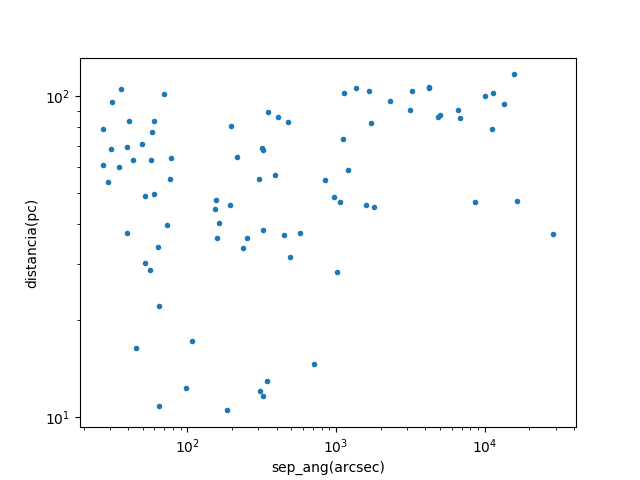

In [20]:
plt.loglog()
decay = seleccion(good_pairs)

plt.xlabel('sep_ang(arcsec)')
plt.ylabel('distancia(pc)')

plt.plot(3600*decay.ang_sep_GDR2,
         1000./ decay.parallax_x,
         '.',)
#plt.legend()

In [6]:
#Hacer tabla para publicar

sigma = 3.0
rvel = 3.0
new_list = good_stars.copy()

new_list['ispmra'] = (np.abs(1.-new_list.pmRA_y/new_list.pmra_y) < sigma*np.abs(
              (new_list.pmRA_y/new_list.pmra_y)*(new_list.e_pmRA_y/new_list.pmRA_y+new_list.pmra_error_y/new_list.pmra_y)))
new_list['ispmde'] = (np.abs(1.-new_list.pmDE_y/new_list.pmdec_y) < sigma*np.abs(
              (new_list.pmDE_y/new_list.pmdec_y)*(new_list.e_pmDE_y/new_list.pmDE_y+new_list.pmdec_error_y/new_list.pmdec_y)))
new_list['isplx']  = ((new_list.parallax_y > 0.85*new_list.parallax_x) & (new_list.parallax_y < 1.15*new_list.parallax_x))
new_list['isrvel'] = ((np.abs(new_list.radial_velocity_x - new_list.radial_velocity_y) < rvel) | (new_list.radial_velocity_x.isna()) | (new_list.radial_velocity_y.isna()))
new_list['dist_y'] = 1000./new_list.parallax_y
new_list['dist_error_y'] = new_list.dist_y*new_list.parallax_error_y/new_list.parallax_y

new_list['logsep']     = np.log10(new_list.proy_sep_GDR2)
new_list['logsep_err'] = new_list.proy_sep_error_GDR2/(np.log(10)*new_list.proy_sep_GDR2)

new_list['comment'] = new_list.ispmra*1 + 2*new_list.ispmde + 4*new_list.isplx + 8*new_list.isrvel
new_list.comment = new_list.comment.replace({0:'a,b,c,d',
                                             1:'b,c,d',
                                             2:'a,c,d',
                                             3:'c,d',
                                             4:'a,b,d',
                                             5:'b,d',
                                             6:'a,d',
                                             7:'d',
                                             8:'a,b,c',
                                             9:'b,c',
                                             10:'a,c',
                                             11:'c',
                                             12:'a,b',
                                             13:'b',
                                             14:'a',
                                             15:'',                                             
                                            })

new_list.shape

#new_list[((new_list.ispmra*1 + 2*new_list.ispmde + 4*new_list.isplx + 8*new_list.isrvel)==15) &
#         (new_list.Pri != new_list.Cmp)].shape
#new_list[new_list.Pri != new_list.Cmp].shape
#new_list.proy_sep_GDR2
#new_list[['Ind','Pri','Cmp','Pri_GDR2','Cmp_GDR2',
#          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
#          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
#          'rel_vel_GDR2','rel_vel_GDR2_err',
#          'comment']]

#.to_csv('new_list.csv')
#new_list

/home/rcortes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


(262, 132)

In [32]:
new_list.comment.where(new_list.Ind!='   ',new_list.comment + '\n \\hline')

8                    
9           \n \hline
10                   
11          \n \hline
17                   
18          \n \hline
19                   
20          \n \hline
21                   
22          \n \hline
23                   
24         c\n \hline
25                   
26          \n \hline
72                   
73       c,d\n \hline
76                   
77          \n \hline
82                   
83          \n \hline
84                   
85          \n \hline
89                   
90          \n \hline
93                   
94         b\n \hline
108                  
109         \n \hline
148                  
149         \n \hline
152                 b
153         \n \hline
157                  
158        b\n \hline
167                  
168         \n \hline
171                  
172         \n \hline
181                  
182        d\n \hline
185                  
186    a,b,d\n \hline
193                  
194         \n \hline
195                  
196       

In [7]:
#new_list.Ind.drop_duplicates(inplace=True)

new_list.proy_sep_GDR2       = new_list.proy_sep_GDR2.where(new_list.Pri != new_list.Cmp)
new_list.proy_sep_error_GDR2 = new_list.proy_sep_error_GDR2.where(new_list.Pri != new_list.Cmp)
new_list.rel_vel_GDR2        = new_list.rel_vel_GDR2.where(new_list.Pri != new_list.Cmp)
new_list.rel_vel_GDR2_err    = new_list.rel_vel_GDR2_err.where(new_list.Pri != new_list.Cmp)

#Eliminar indices repetidos
new_list['Ind2'] = new_list.Ind.copy()
new_list.Ind = new_list.Ind.astype(np.str)
new_list.Ind = new_list.Ind.where(new_list.Pri == new_list.Cmp,
                                  other='   ')
#Eliminar primarias repetidas
new_list.Pri = new_list.Pri.astype(np.str)
new_list.Cmp = new_list.Cmp.astype(np.str)
#new_list.Cmp = new_list.Cmp.where(new_list.Pri != new_list.Cmp,
#                                  other='      ')

#Eliminar compañeras repetidas
new_list.Pri_GDR2 = new_list.Pri_GDR2.astype(np.str)
new_list.Cmp_GDR2 = new_list.Cmp_GDR2.astype(np.str)
#new_list.Cmp_GDR2 = new_list.Cmp_GDR2.where(new_list.Pri_GDR2 != new_list.Cmp_GDR2,
#                                            other='                   ')
# Convertir los puntos flotante a cadena con formato:
new_list['pmrapmerr']  = new_list.pmra_y.map('{:6.3f}'.format)+'$\\pm$'+new_list.pmra_error_y.map('{:.3f}'.format)
new_list['pmdecpmerr'] = new_list.pmdec_y.map('{:6.3f}'.format)+'$\\pm$'+new_list.pmdec_error_y.map('{:.3f}'.format)
#  Radial velocity
new_list['radvelpmerr']= new_list.radial_velocity_y.map('{:6.2f}'.format)+'$\\pm$'+new_list.radial_velocity_error_y.map('{:6.2f}'.format)
new_list.radvelpmerr   = new_list.radvelpmerr.where(new_list.radvelpmerr != '   nan$\\pm$   nan',
                                                    other='             ')
#
new_list['distpmerr']  = new_list.dist_y.map('{:6.3f}'.format)+'$\\pm$'+new_list.dist_error_y.map('{:.3f}'.format)
new_list['dRpmerr']    = new_list.logsep.map('{:6.3f}'.format)+'$\\pm$'+new_list.logsep_err.map('{:.3f}'.format)
new_list.dRpmerr       = new_list.dRpmerr.where(new_list.Pri != new_list.Cmp,
#new_list.dRpmerr       = new_list.dRpmerr.where(new_list.dRpmerr != 'NAN$\\pm$NAN',
                                                other='               ')
new_list['dvpmerr'] = new_list.rel_vel_GDR2.map('{:6.3f}'.format)+'$\\pm$'+new_list.rel_vel_GDR2_err.map('{:.3f}'.format)
new_list.dvpmerr    = new_list.dvpmerr.where(new_list.dvpmerr != '   nan$\pm$nan',
                                                    other='             ')


#new_list.pmra_error_y = new_list.pmra_error_y.map('{:6.3f}'.format)

#new_list[['Ind','Pri','Cmp','Pri_GDR2','Cmp_GDR2',
#          'pmrapmerr', 'pmdecpmerr','distpmerr',
#          'dRpmerr','dvpmerr',
#          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
#          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
#          'rel_vel_GDR2','rel_vel_GDR2_err',
#          'comment']]
new_list[['Ind','Cmp','Cmp_GDR2',
          'pmrapmerr', 'pmdecpmerr','radvelpmerr',
          'distpmerr',
          'dRpmerr','dvpmerr',
#          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
#          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
#          'rel_vel_GDR2','rel_vel_GDR2_err',
          'comment']]

Ind     Cmp             Cmp_GDR2           pmrapmerr  \
8     16   15371  4722135642226356736  1331.151$\pm$0.355   
9          15330  4722111590409480064  1337.591$\pm$0.142   
10    17   17414    43335880716390784   157.945$\pm$0.086   
11         17405    43335537119008896   156.215$\pm$0.089   
17    21   19859  3285218186904332288  -109.700$\pm$0.095   
18         19855  3285218255623808640  -101.763$\pm$0.080   
19    22   23693  4763906879239461632   -32.140$\pm$0.276   
20         23708  4763897739549071744   -32.784$\pm$0.049   
21    25   25278  3400292798990117888   250.765$\pm$0.316   
22         25220  3394298532176344960   251.000$\pm$0.092   
23    28   26690  3395863205942142976     2.551$\pm$0.100   
24         26844  3347826784173590656    79.115$\pm$0.087   
25    29   26779   263916708025623680     2.784$\pm$0.075   
26         26801   263916742385357056     3.915$\pm$0.078   
72    65   62229  6060965699625586176  -201.033$\pm$0.052   
73         69570  6092573252981419776  -102.218$\pm$0.095   
76    73   70529  1254695603704323712   792.548$\pm$0.092   
77         70536  1254694882149817728   793.487$\pm$0.085   
82    80   79755  1642641410934267008  -498.018$\pm$0.050   
83         79762  1642642957122493824  -483.168$\pm$0.066   
84    81   80337  6018047019138644480    74.146$\pm$0.306   
85         80300  6018034958869558912    77.135$\pm$0.147   
89    85   83591  4364527594192166400  -916.562$\pm$0.155   
90         83599  4364480521350598144  -917.276$\pm$0.098   
93    87   84405  4109030160308317312  -466.541$\pm$0.646   
94         84478  4109034455276324608  -479.850$\pm$0.101   
108  112     493  2797111130991722240  -150.936$\pm$0.121   
109          495  2773086595766697856  -147.614$\pm$0.094   
148  130    7699  4911275281704066048    91.146$\pm$0.041   
149         6485  4909846500703006976    92.790$\pm$0.045   
152  132    9487  2517584007848935808    32.692$\pm$0.940   
153         9519  2517585927699042944    36.368$\pm$0.126   
157  140   11477  4967177781457918976    18.526$\pm$0.121   
158        11448  4967153630858709120    18.383$\pm$0.030   
167  155   15304    10584899657116672   166.360$\pm$0.071   
168        15310    10608573516849536   168.749$\pm$0.073   
171  157   15527  5060104351007433472   349.057$\pm$0.036   
172        15526  5060105892897388288   348.847$\pm$0.065   
181  173   22534  4777112872882315264   -80.769$\pm$0.929   
182        22562  4777119126354782592   -82.413$\pm$0.043   
185  175   24046  3422042582096699520   197.860$\pm$0.093   
186        24035  3422047495539178496   198.179$\pm$0.596   
193  187   33705  5607190344506642432    18.789$\pm$0.043   
194        33691  5607189485513198208    18.893$\pm$0.061   
195  190   34714   890422213103244544  -110.510$\pm$0.075   
196        34700   890346243721923968  -110.866$\pm$0.102   
201  195   37718  5493209501673364736  -114.435$\pm$0.047   
202        37727  5493209437253410432  -111.783$\pm$0.060   
209  201   42401  5746824674801810816   -63.858$\pm$0.051   
210        41662  5751951182125903872   -56.556$\pm$0.064   
213  204   43970   610526719204475136    60.337$\pm$0.292   
214        44001   610549499710989440    60.440$\pm$0.161   
217  207   44858   692119656035933568   -53.239$\pm$0.128   
218        44864   692120029700390912   -51.819$\pm$0.113   
221  215   51312   749786562715192320  -111.186$\pm$0.069   
222        52140   748360706587700352  -110.338$\pm$0.106   
223  218   52787  3550081879381593728  -124.690$\pm$0.115   
224        52776  3550084490721711872  -124.539$\pm$0.112   
230  224   55765  3967618155853506304  -142.347$\pm$0.204   
231        55262  3965063921622777856  -146.589$\pm$0.080   
236  229   58067  3975129194660883328  -450.502$\pm$0.095   
237        58073  3975223065466473216  -450.600$\pm$0.083   
238  230   58085  5236197322996128128    13.792$\pm$0.037   
239        58121  5236196498362394112    12.724$\pm$0.048   
246  245   64057  3945118265299248128  -

In [16]:
new_list.ang_sep_GDR2        = 3600*new_list.ang_sep_GDR2
new_list.ang_sep_GDR2_err    = 3600*new_list.ang_sep_GDR2_err
new_list.proy_sep_GDR2       = (3.085678E18/1.49597871E13)*new_list.proy_sep_GDR2
new_list.proy_sep_error_GDR2 = (3.085678E18/1.49597871E13)*new_list.proy_sep_error_GDR2

In [9]:
filename='table01.dat'
archivo = open(filename,'w')
archivo.write('#List of pairs with uncertainties, only those with blank comments were selected.\n#')
archivo.write(new_list[['Ind2','Cmp','Cmp_GDR2',
                        'ra_y','dec_y',
          'pmrapmerr', 'pmdecpmerr','radvelpmerr',
          'distpmerr',
          'dRpmerr','dvpmerr',
#          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
#          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
#          'rel_vel_GDR2','rel_vel_GDR2_err',
          'comment']].to_string(index=False).replace('$\\pm$', '  '))
archivo.close()

In [9]:
seleccion(good_stars)

Ind             Pri_GDR2             Cmp_GDR2     Pri     Cmp   GLON  \
8     16  4722135642226356736  4722135642226356736   15371   15371  279.0   
9     16  4722135642226356736  4722111590409480064   15371   15330  279.1   
10    17    43335880716390784    43335880716390784   17414   17414  171.7   
11    17    43335880716390784    43335537119008896   17414   17405  171.7   
17    21  3285218186904332288  3285218186904332288   19859   19859  186.7   
18    21  3285218186904332288  3285218255623808640   19859   19855  186.7   
19    22  4763906879239461632  4763906879239461632   23693   23693  266.0   
20    22  4763906879239461632  4763897739549071744   23693   23708  266.1   
21    25  3400292798990117888  3400292798990117888   25278   25278  187.2   
22    25  3400292798990117888  3394298532176344960   25278   25220  187.1   
23    28  3395863205942142976  3395863205942142976   26690   26690  191.0   
25    29   263916708025623680   263916708025623680   26779   26779  158.4   
26    29   263916708025623680   263916742385357056   26779   26801  158.4   
72    65  6060965699625586176  6060965699625586176   62229   62229  302.1   
76    73  1254695603704323712  1254695603704323712   70529   70529   28.8   
77    73  1254695603704323712  1254694882149817728   70529   70536   28.8   
82    80  1642641410934267008  1642641410934267008   79755   79755   99.9   
83    80  1642641410934267008  1642642957122493824   79755   79762   99.9   
84    81  6018047019138644480  6018047019138644480   80337   80337  341.6   
85    81  6018047019138644480  6018034958869558912   80337   80300  341.5   
89    85  4364527594192166400  4364527594192166400   83591   83591   15.4   
90    85  4364527594192166400  4364480521350598144   83591   83599   15.4   
93    87  4109030160308317312  4109030160308317312   84405   84405  358.3   
108  112  2797111130991722240  2797111130991722240     493     493  108.0   
109  112  2797111130991722240  2773086595766697856     493     495  108.0   
148  130  4911275281704066048  4911275281704066048    7699    7699  289.9   
149  130  4911275281704066048  4909846500703006976    7699    6485  294.6   
157  140  4967177781457918976  4967177781457918976   11477   11477  236.7   
167  155    10584899657116672    10584899657116672   15304   15304  173.7   
168  155    10584899657116672    10608573516849536   15304   15310  173.7   
171  157  5060104351007433472  5060104351007433472   15527   15527  224.8   
172  157  5060104351007433472  5060105892897388288   15527   15526  224.7   
181  173  4777112872882315264  4777112872882315264   22534   22534  261.3   
185  175  3422042582096699520  3422042582096699520   24046   24046  176.8   
193  187  5607190344506642432  5607190344506642432   33705   33705  242.0   
194  187  5607190344506642432  5607189485513198208   33705   33691  242.1   
195  190   890422213103244544   890422213103244544   34714   34714  184.4   
196  190   890422213103244544   890346243721923968   34714   34700  184.9   
201  195  5493209501673364736  5493209501673364736   37718   37718  263.5   
202  195  5493209501673364736  5493209437253410432   37718   37727  263.5   
209  201  5746824674801810816  5746824674801810816   42401   42401  237.9   
213  204   610526719204475136   610526719204475136   43970   43970  212.5   
214  204   610526719204475136   610549499710989440   43970   44001  212.3   
217  207   692119656035933568   692119656035933568   44858   44858  198.8   
218  207   692119656035933568   692120029700390912   44858   44864  198.8   
221  215   749786562715192320   749786562715192320   51312   51312  189.7   
223  218  3550081879381593728  3550081879381593728   52787   52787  268.7   
224  218  3550081879381593728  3550084490721711872   52787   52776  268.7   
230  224  3967618155853506304  3967618155853506304   55765   55765  236.8   
236  229  3975129194660883328  3975129194660883328   58067   58067  240.5   
237  229  3975129194660883328  3975223065466473216   58067   58073  240.5   
2

In [15]:
filename='table01.csv'
archivo = open(filename,'w')
archivo.write('#List of pairs with uncertainties, only those with blank comments were selected.\n#')
archivo.write(new_list[['Ind','Cmp','Cmp_GDR2',
                        'pmra_y', 'pmra_error_y',
                        'pmdec_y','pmdec_error_y',
                        'radial_velocity_y','radial_velocity_error_y',
                        'distance_y','distance_error_y',
                        'logsep','logsep_err',
                        'rel_vel_GDR2','rel_vel_GDR2_err',
#          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
#          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
#          'rel_vel_GDR2','rel_vel_GDR2_err',
                        'comment']].to_csv(index=False,
                                           header=['Ind','Cmp','Cmp_GDR2',
                                                   'pmra', 'pmra_error',
                                                   'pmdec','pmdec_error',
                                                   'v_r','v_r_error',
                                                   'dist','dist_error',
                                                   'logsep','logsep_err',
                                                   'dvpm','dvpm_err','comment'],
                                          na_rep='NaN').replace('-inf','NaN').replace('inf','NaN'))
archivo.close()

In [13]:
new_list.to_csv?

In [26]:
filename='correciones.tex'
archivo = open(filename,'w')
corr = seleccion(good_pairs)
archivo.write(corr[['Ind','Pri','Cmp',
                    'ra_x','dec_x','parallax_x',
                    'pmra_x','pmdec_x','radial_velocity_x',
                    'ra_y','dec_y','parallax_y',
                    'pmra_y','pmdec_y','radial_velocity_y',                        
#                    'U','V','W',
                    'pmra_corr','pmde_corr']].to_latex(index=False,
                                                                   longtable=True,
                                                                   escape=True))

20190

In [20]:
np.arccos(0)

1.5707963267948966

In [29]:
#new_list[new_list.ispmra].shape
new_list['pardiff'] = 1000.*np.abs(1/new_list.parallax_x - 1/new_list.parallax_y)
new_list['pardiff_err'] = 1000.*np.abs(new_list.parallax_error_x/(new_list.parallax_x)**2 -
                                       new_list.parallax_error_y/(new_list.parallax_y)**2)
new_list['pardiffpercent'] = 100*np.abs(1.-new_list.parallax_y/new_list.parallax_x)
#new_list.sort_values('pardiff')
new_list[['Ind','comment']]
0

0

In [37]:
#TAbla tex analisis
filename='tabla_hor.tex'
archivo = open(filename,'w')
archivo.write('\\small\n')
archivo.write(new_list[['Ind','Pri','Cmp',
                        'RAdeg_x','e_RAdeg_x',
                        'DEdeg_x','e_DEdeg_x',
                        'Plx_x','e_Plx_x',
                        'pmRA_x','e_pmRA_x',
                        'pmDE_x','e_pmDE_x']].to_latex(index=False,
#                        'RAdeg_y','DEdeg_y',
#                        'e_RAdeg_y','e_RAdeg_y',
#                        'Plx_y','e_Plx_y',
#                        'pmRA_y','e_pmRA_y',
#                        'pmDE_y','e_pmDE_y']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                      header=['Ind','Pri','Cmp',
                                                              'RAdeg_x','err',
                                                              'DEdeg_x','err',
                                                              'Plx_x','err',
                                                              'pmRA_x','err',
                                                              'pmDE_x','err']
                                                       ))
archivo.write('\\pagebreak\n')
archivo.write(new_list[['Ind',
                        'RAdeg_y','e_RAdeg_y',
                        'DEdeg_y','e_DEdeg_y',
                        'Plx_y','e_Plx_y',
                        'pmRA_y','e_pmRA_y',
                        'pmDE_y','e_pmDE_y']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                      header=['Ind',
                                                              'RAdeg_y','err',
                                                              'DEdeg_y','err',
                                                              'Plx_y','err',
                                                              'pmRA_y','err',
                                                              'pmDE_y','err']                                                       
                                                      ))
archivo.write('\\pagebreak\n')
archivo.write(new_list[['Ind',
                        'ra_x','ra_error_x',
                        'dec_x','dec_error_x',
                        'parallax_x','parallax_error_x',
                        'pmra_x','pmra_error_x',
                        'pmdec_x','pmdec_error_x']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                             header=['Ind',
                                                                     'ra_x','err',
                                                                     'dec_x','err',
                                                                     'plx_x','err',
                                                                     'pmra_x','err',
                                                                     'pmdec_x','err']
                                                             ))
archivo.write('\\pagebreak\n')
archivo.write(new_list[['Ind',
                        'ra_y','ra_error_y',
                        'dec_y','dec_error_y',
                        'parallax_y','parallax_error_y',
                        'pmra_y','pmra_error_y',
                        'pmdec_y','pmdec_error_y']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                             header=['Ind',
                                                                     'ra_y','err',
                                                                     'dec_y','err',
                                                                     'plx_y','err',
                                                                     'pmra_y','err',
                                                                     'pmdec_y','err']                                                             
                                                      ))
archivo.write('\\pagebreak\n')
archivo.write(new_list[['Ind',
                        'dpmra_HIP','dpmra_HIP_err',
                        'dpmde_HIP','dpmde_HIP_err',
                        'cos_angsep_HIP','dcos_angsep_HIP',
                        'proy_sep_HIP','proy_sep_error_HIP',
                        'rel_vel_HIP','rel_vel_HIP_err']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                                   header=['Ind',
                                                                           'dpmra_HIP','err',
                                                                           'dpmde_HIP','err',
                                                                           'cos_th_HIP','err',
                                                                           'dR_HIP','err',
                                                                           'dV_HIP','err']
                                                                   ))
archivo.write('\\pagebreak\n')
archivo.write(new_list[['Ind',
                        'dpmra_GDR2','dpmra_GDR2_err',
                        'dpmde_GDR2','dpmde_GDR2_err',
                        'cos_angsep_GDR2','dcos_angsep_GDR2',
                        'proy_sep_GDR2','proy_sep_error_GDR2',
                        'rel_vel_GDR2','rel_vel_GDR2_err']].to_latex(index=False,
                                                      longtable=True,
                                                      escape=True,
                                                      header=['Ind',
                                                              'dpmra_G','err',
                                                              'dpmde_G','err',
                                                              'cos_th_G','err',
                                                              'dR_G','err',
                                                              'dV_G','err']
                                                      ))
archivo.close()

In [40]:
#TAbla tex
filename='tabla_01.tex'
archivo = open(filename,'w')

proposterous = new_list.copy()
# Para añadir la línea horizontal entre binarias
proposterous.Ind = proposterous.Ind.where(proposterous.Ind=='   ',"\\hline " + proposterous.Ind)

archivo.write(proposterous[['Ind','Cmp','Cmp_GDR2',
                        'pmrapmerr', 'pmdecpmerr','radvelpmerr',
                        'distpmerr',
                        'dRpmerr',
                        #'dvpmerr',
                        'comment']].to_latex(column_format='rrrrrrrrl',
                               index=False,
                               longtable=True,
                               escape=False,
                               header=['Index',
                                       'HIP2',
                                       '\\multicolumn{1}{c}{GDR2}',
                                       '\\multicolumn{1}{c}{$\\mu_\\alpha$}',
                                       '\\multicolumn{1}{c}{$\\mu_\\delta$}',
                                       '\\multicolumn{1}{c}{$v_r$}',
                                       '\\multicolumn{1}{c}{$d$}',
                                       '\\multicolumn{1}{c}{$\\log_{10}(\\Delta R)$}',
#                                       '\\multicolumn{1}{c}{$\\Delta v_{\\perp}$}',
                                       'Exclusion\\\\\n \\cmidrule(lr){4-5} \\cmidrule(lr){7-8}\n\\multicolumn{1}{c}{SO11}  &  & & \\multicolumn{2}{c}{(mas/yr)} & \\multicolumn{1}{c}{(km/s)} & \\multicolumn{2}{c}{(pc)}& \\multicolumn{1}{c}{Test}']))
archivo.close()

In [42]:
#TAbla tex con coordenadas
filename='tabla_01_coords.tex'
archivo = open(filename,'w')

proposterous = new_list.copy()
# Para añadir la línea horizontal entre binarias
proposterous.Ind = proposterous.Ind.where(proposterous.Ind=='   ',"\\hline " + proposterous.Ind)
archivo.write(proposterous[['Ind','Cmp','Cmp_GDR2',
                            'ra_y','dec_y',
                            'pmrapmerr', 'pmdecpmerr','radvelpmerr',
                            'distpmerr',
                            'dRpmerr',
                            #'dvpmerr',
                            'comment']].to_latex(column_format='rrrrrrrrrrl',
                               index=False,
                               longtable=True,
                               escape=False,
                               header=['Index',
                                       'HIP2',
                                       '\\multicolumn{1}{c}{GDR2}',
                                       '\\multicolumn{1}{c}{$\\alpha$}',
                                       '\\multicolumn{1}{c}{$\\delta$}',                                       
                                       '\\multicolumn{1}{c}{$\\mu_\\alpha$}',
                                       '\\multicolumn{1}{c}{$\\mu_\\delta$}',
                                       '\\multicolumn{1}{c}{$v_r$}',
                                       '\\multicolumn{1}{c}{$d$}',
                                       '\\multicolumn{1}{c}{$\\log_{10}(\\Delta R)$}',
#                                       '\\multicolumn{1}{c}{$\\Delta v_{\\perp}$}',
                                       'Exclusion\\\\\n \\cmidrule(lr){6-7} \\cmidrule(lr){9-10}\n\\multicolumn{1}{c}{SO11}  &  & & \\multicolumn{2}{c}{(deg)} & \\multicolumn{2}{c}{(mas/yr)} & \\multicolumn{1}{c}{(km/s)} & \\multicolumn{2}{c}{(pc)}& \\multicolumn{1}{c}{Test}']))
archivo.close()

In [45]:
np.string_('%3.2f'%(np.linspace(0,10)))

TypeError: only size-1 arrays can be converted to Python scalars

In [105]:
new_list[['Ind','Pri','Cmp','Pri_GDR2','Cmp_GDR2',
          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
          'rel_vel_GDR2','rel_vel_GDR2_err',
          'comment']].to_csv('x.csv',
                             na_rep='          ',
                             header=True,
                             float_format='%10.6g',
                             index=False)
#For Latex

new_list[['Ind','Pri','Cmp','Pri_GDR2','Cmp_GDR2',
          'pmra_y','pmra_error_y','pmdec_y','pmdec_error_y',
          'dist_y','dist_error_y','proy_sep_GDR2','proy_sep_error_GDR2',
          'rel_vel_GDR2','rel_vel_GDR2_err',
          'comment']].to_csv('latex.csv',
                             na_rep='          ',
                             sep='&',
                             float_format='%10.6g',
                             line_terminator='\\\\\n',
                             index=False)


<IPython.core.display.Javascript object>


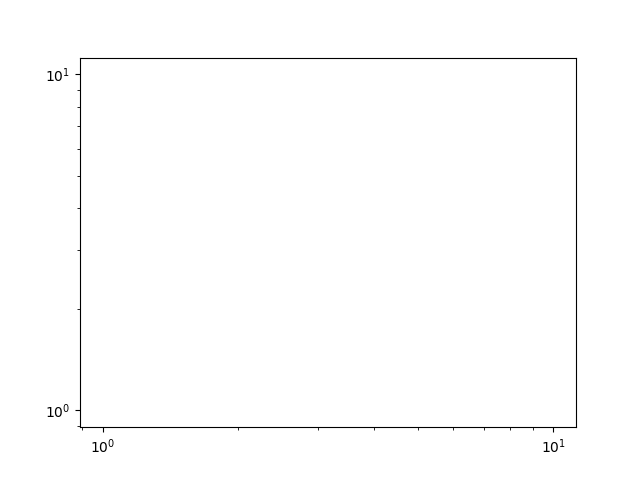

NameError: name 'shaya' is not defined

In [15]:
#Diagrama separacion velocidad
plt.loglog()

plt.title('Velocidad tangencial')
plt.xlabel('$\Delta$ R(pc)')
plt.ylabel('$\Delta$v(km/s)')

plt.xlim((1E-3,10**1.5))
plt.ylim((1E-2,1E2))

c = (np.pi*3.086E13)/(180*3600*1000*365*24*3600.)


plt.plot(good_pairs.dR,
         c*np.sqrt(good_pairs.dpmb**2+good_pairs.dpml**2)*good_pairs.Dis,
         '.',
         label='Shaya con correspondencia')

#plt.errorbar(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
#            good_pairs.rel_vel_HIP_err,
#            linewidth=1,fmt='.',capsize=3)

"""
for i in good_pairs.index:
    plt.text(good_pairs.proy_sep_GDR2[i],
             good_pairs.rel_vel_GDR2[i],
             str(good_pairs.Ind[i]),
            fontsize=10)

plt.errorbar(good_pairs.proy_sep_GDR2,good_pairs.rel_vel_GDR2,
            good_pairs.rel_vel_GDR2_err,
            linewidth=1,fmt='.',capsize=3,
            label='GDR2')
"""
for i in good_pairs.index:
    if good_pairs.Ind[i]:
    plt.text(good_pairs.proy_sep_HIP[i],
             good_pairs.rel_vel_HIP[i],
             str(good_pairs.Ind[i]),
            fontsize=10)
"""
plt.errorbar(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
            good_pairs.rel_vel_HIP_err,
            linewidth=1,fmt='v',capsize=3,
            label='HIP')
"""
"""         
plt.plot(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
            '.',
            label='HIP')
"""         

# G*Msol = 0.0921 pc^-(1/2) km/s
plt.plot(np.logspace(-3,2),
         np.sqrt(36*4.306E-3)*np.power(np.logspace(-3,2),-.5),
         label='Newtonian limit')
#plt.show()
#plt.savefig('1vs2__.png')

plt.legend()

IndentationError: expected an indented block (<ipython-input-15-4c5ccfefd6a7>, line 37)

<IPython.core.display.Javascript object>


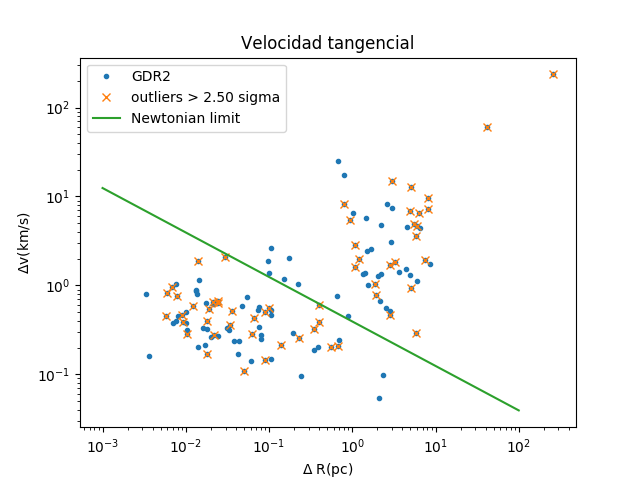

(56, 119)

In [6]:
#Diagrama separacion velocidad
plt.loglog()

plt.title('Velocidad tangencial')
plt.xlabel('$\Delta$ R(pc)')
plt.ylabel('$\Delta$v(km/s)')

#plt.xlim((1E-3,10**1.5))
#plt.ylim((1E-2,1E2))

c = (np.pi*3.086E13)/(180*3600*1000*365*24*3600.)


plt.plot(good_pairs.proy_sep_GDR2,
         good_pairs.rel_vel_GDR2,
         '.',
         label='GDR2')

#plt.errorbar(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
#            good_pairs.rel_vel_HIP_err,
#            linewidth=1,fmt='.',capsize=3)

x = good_pairs.copy()
sig = 2.5


x = x[(np.abs(1.-x.pmRA_y/x.pmra_y) > sig*np.abs(
              (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) |
          (np.abs(1.-x.pmDE_y/x.pmdec_y) > sig*np.abs(
              (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) |
          (np.abs(1.-x.Plx_y/x.parallax_y) > sig*np.abs(
              (x.Plx_y/x.parallax_y)*(x.e_Plx_y/x.Plx_y+x.parallax_error_y/x.parallax_y))) |
      (np.abs(1.-x.pmRA_x/x.pmra_x) > sig*np.abs(
              (x.pmRA_x/x.pmra_x)*(x.e_pmRA_x/x.pmRA_x+x.pmra_error_x/x.pmra_x))) |
          (np.abs(1.-x.pmDE_y/x.pmdec_y) > sig*np.abs(
              (x.pmDE_x/x.pmdec_x)*(x.e_pmDE_x/x.pmDE_x+x.pmdec_error_x/x.pmdec_x))) |
          (np.abs(1.-x.Plx_x/x.parallax_x) > sig*np.abs(
              (x.Plx_x/x.parallax_x)*(x.e_Plx_x/x.Plx_x+x.parallax_error_x/x.parallax_x))) &
         True]



plt.plot(x.proy_sep_GDR2,
         x.rel_vel_GDR2,
         'x',
         label='outliers > %.2f sigma'%sig)
"""
for i in good_pairs.index:
    plt.text(good_pairs.proy_sep_GDR2[i],
             good_pairs.rel_vel_GDR2[i],
             str(good_pairs.Ind[i]),
            fontsize=10)

plt.errorbar(good_pairs.proy_sep_GDR2[5],good_pairs.rel_vel_GDR2[5],
            good_pairs.rel_vel_GDR2_err[5],
            linewidth=1,fmt='.',capsize=3,
            )

for i in good_pairs.index:
    plt.text(good_pairs.proy_sep_HIP[i],
             good_pairs.rel_vel_HIP[i],
             str(good_pairs.Ind[i]),
            fontsize=10)

plt.errorbar(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
            good_pairs.rel_vel_HIP_err,
            linewidth=1,fmt='v',capsize=3,
            label='HIP')
"""
         
"""         
plt.plot(good_pairs.proy_sep_HIP,good_pairs.rel_vel_HIP,
            '.',
            label='HIP')
"""         

# G*Msol = 0.0921 pc^-(1/2) km/s
plt.plot(np.logspace(-3,2),
         np.sqrt(36*4.306E-3)*np.power(np.logspace(-3,2),-.5),
         label='Newtonian limit')
#plt.show()
#plt.savefig('1vs2__.png')

plt.legend()

good_pairs.shape
x.shape

0.004744213026078222

<IPython.core.display.Javascript object>


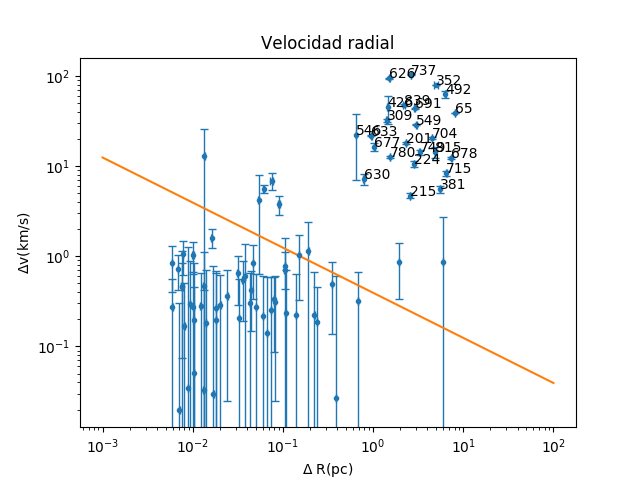

In [5]:
#Diagrama separacion velocidad radial
plt.loglog()

plt.title('Velocidad radial')
plt.xlabel('$\Delta$ R(pc)')
plt.ylabel('$\Delta$v(km/s)')

#plt.xlim((1E-3,10**1.5))
#plt.ylim((1E-2,1E2))

c = (np.pi*3.086E13)/(180*3600*1000*365*24*3600.)

x_temp = good_pairs[~good_pairs.radial_velocity_y.isna() &
               ~good_pairs.radial_velocity_x.isna()]


plt.errorbar(x_temp.proy_sep_GDR2,
             np.abs(x_temp.radial_velocity_y - x_temp.radial_velocity_x),
             np.abs(x_temp.radial_velocity_error_x) + np.abs(x_temp.radial_velocity_error_y),
             x_temp.proy_sep_error_GDR2,
             linewidth=1,fmt='.',capsize=3,
             label='GDR2')
for i in x_temp.index:
    if np.abs(x_temp.radial_velocity_y[i] - x_temp.radial_velocity_x[i]) > 10*np.sqrt(36*4.306E-3)*x_temp.proy_sep_GDR2[i]**-.5:
        plt.text(x_temp.proy_sep_GDR2[i],
                 np.abs(x_temp.radial_velocity_y[i] - x_temp.radial_velocity_x[i]),
                 str(x_temp.Ind[i]),
                 fontsize=10)
"""
plt.plot(x_temp.proy_sep_GDR2,
             np.abs(x_temp.radial_velocity_y - x_temp.radial_velocity_x),
         '.',
             linewidth=1,
             label='GDR2')
"""

# G*Msol = 0.0921 pc^-(1/2) km/s
plt.plot(np.logspace(-3,2),
         np.sqrt(36*4.306E-3)*np.power(np.logspace(-3,2),-.5),
         label='Newtonian limit')
#plt.show()
#plt.savefig('1vs2__.png')

"""
x = good_pairs.copy()
sig = 1.5


x = x[(np.abs(1.-x.pmRA_y/x.pmra_y) > sig*np.abs(
              (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) |
          (np.abs(1.-x.pmDE_y/x.pmdec_y) > sig*np.abs(
              (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) |
          (np.abs(1.-x.Plx_y/x.parallax_y) > sig*np.abs(
              (x.Plx_y/x.parallax_y)*(x.e_Plx_y/x.Plx_y+x.parallax_error_y/x.parallax_y))) |
      (np.abs(1.-x.pmRA_x/x.pmra_x) > sig*np.abs(
              (x.pmRA_x/x.pmra_x)*(x.e_pmRA_x/x.pmRA_x+x.pmra_error_x/x.pmra_x))) |
          (np.abs(1.-x.pmDE_y/x.pmdec_y) > sig*np.abs(
              (x.pmDE_x/x.pmdec_x)*(x.e_pmDE_x/x.pmDE_x+x.pmdec_error_x/x.pmdec_x))) |
          (np.abs(1.-x.Plx_x/x.parallax_x) > sig*np.abs(
              (x.Plx_x/x.parallax_x)*(x.e_Plx_x/x.Plx_x+x.parallax_error_x/x.parallax_x))) &
         True]



plt.plot(x.proy_sep_GDR2,
         np.abs(x.radial_velocity_y - x.radial_velocity_x),
         'x',
         label='outliers > %.2f sigma'%sig)
"""            
plt.show()
#plt.legend()

In [104]:
# Movimientos propios ascención recta

show_index = False

lim = 2

#plt.title('HIP2/GDR2 en mov. prop. r.a.')
plt.xlabel('HIP catalogue number',fontsize=15)
plt.ylabel(r'$\frac{ \mu_{\alpha GDR2} - \mu_{\alpha HIP2}}{\mu_{\alpha GDR2}}$',
           fontsize=15)
#plt.ylabel('$\frac{\mu_{aGDR2}-\mu_{aHIP2}}{\mu_{aGDR2}}$',fontsize=15)

plt.ylim(-.5,.5)

values = ['Cmp','pmra_y','pmRA_y','pmra_error_y','e_pmRA_y']

x = good_pairs[values].sort_values('Cmp')

#x = x[np.abs(1.-x.pmRA_y/x.pmra_y) < lim*np.abs(
#        (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))]

x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]

if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(x0,x0*0.)
plt.errorbar(x0,1-x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='+',
             capsize=3,
             linewidth = 0.7)
"""
#------Excluidas
x = good_pairs[values].sort_values('Cmp')
x = x[np.abs(1.-x.pmRA_y/x.pmra_y) > lim*np.abs(
        (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))]

x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]

plt.errorbar(x0,x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='x',
             capsize=3,
             linewidth = 0.7)
"""
x.shape

/home/rcortes/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


(151, 5)

<IPython.core.display.Javascript object>


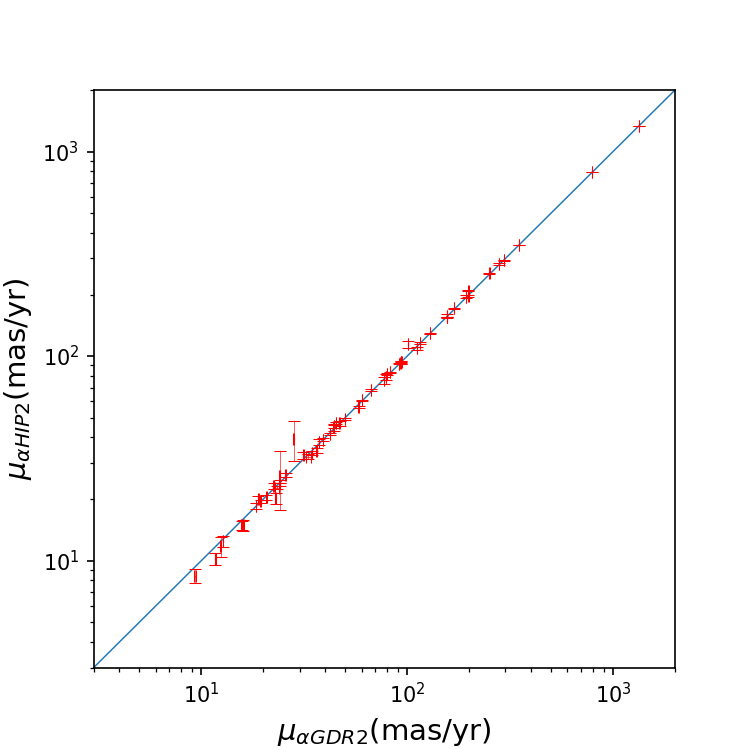

In [105]:
# Movimientos propios r.a.

fig = plt.figure(figsize=(5,5),dpi=150)
figname='fig01'

fnt=14
show_index = False

plt.loglog()

#plt.title('HIP2 vs. GDR2 en mov. prop. r.a.')
plt.xlabel(r'$\mu_{\alpha GDR2}$(mas/yr)',fontsize=fnt)
plt.ylabel(r'$\mu_{\alpha HIP2}$(mas/yr)',fontsize=fnt)

plt.xlim(3,2000)
plt.ylim(3,2000)

values = ['Cmp','pmra_y','pmRA_y','pmra_error_y','e_pmRA_y']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]


if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(np.linspace(x1.min(),x1.max()+1000,100),
         np.linspace(x1.min(),x1.max()+1000,100),
         linewidth=0.7)
plt.errorbar(x1,x2,
             x4,x3,
             fmt='r.',
             markersize=0.1,
             capsize=3,
             capthick=0.5,
             linewidth = 0.3)
plt.savefig('%s.png'%figname)
plt.savefig('%s.jpg'%figname)
plt.savefig('%s.ps'%figname)
plt.savefig('%s.pdf'%figname)

<IPython.core.display.Javascript object>


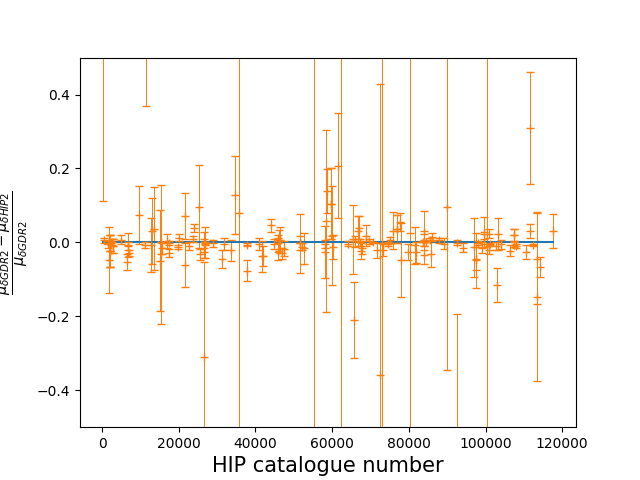

<ErrorbarContainer object of 3 artists>

In [19]:
# Movimientos propios declinación
show_index = False

#plt.title('HIP2/GDR2 en mov. prop. dec.')
plt.xlabel('HIP catalogue number',fontsize=15)
plt.ylabel(r'$\frac{ \mu_{\delta GDR2} - \mu_{\delta HIP2}}{\mu_{\delta GDR2}}$',
           fontsize=15)
plt.ylim(-.5,.5)

values = ['Cmp','pmdec_y','pmDE_y','pmdec_error_y','e_pmDE_y']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]


if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(x0,x0*0)
plt.errorbar(x0,1-x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='+',
             capsize=3,
             linewidth = 0.7)

In [106]:
# Movimientos propios declinación
fig = plt.figure(figsize=(5,5),dpi=150)
figname='fig02'

fnt=14
show_index = False
plt.loglog()

#plt.title('HIP2 vs. GDR2 en mov. prop. dec.')
plt.xlabel(r'$\mu_{\delta GDR2}$(mas/yr)',fontsize=fnt)
plt.ylabel(r'$\mu_{\delta HIP2}$(mas/yr)',fontsize=fnt)

plt.xlim(3,2000)
plt.ylim(3,2000)

values = ['Cmp','pmdec_y','pmDE_y','pmdec_error_y','e_pmDE_y']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]


if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(np.linspace(x1.min(),x1.max()+2000,100),
         np.linspace(x1.min(),x1.max()+2000,100),
         linewidth=0.7)
plt.errorbar(x1,x2,
             x4,x3,
             fmt='r.',
             markersize=0.1,
             capsize=3,
             capthick=0.5,
             linewidth = 0.3)
plt.savefig('%s.png'%figname)
plt.savefig('%s.jpg'%figname)
plt.savefig('%s.ps'%figname)
plt.savefig('%s.pdf'%figname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


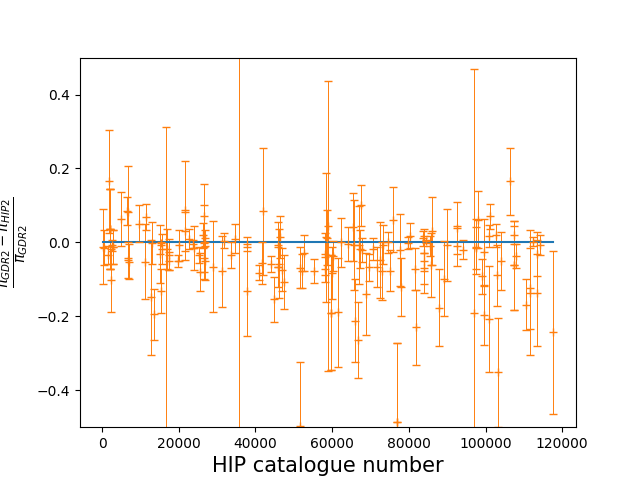

<ErrorbarContainer object of 3 artists>

In [21]:
# Paralajes
show_index = False

#plt.title('HIP2/GDR2 en parallax')
plt.xlabel('HIP catalogue number', fontsize=15)
plt.ylabel(r'$\frac{ \pi_{GDR2} - \pi_{HIP2}}{\pi_{GDR2}}$',
           fontsize=15)

plt.ylim(-.5,.5)


values = ['Cmp','parallax_y','Plx_y','parallax_error_y','e_Plx_y']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]

if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(x0,x0*0.)
plt.errorbar(x0,1-x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='+',
             capsize=3,
             linewidth = 0.7)

<IPython.core.display.Javascript object>


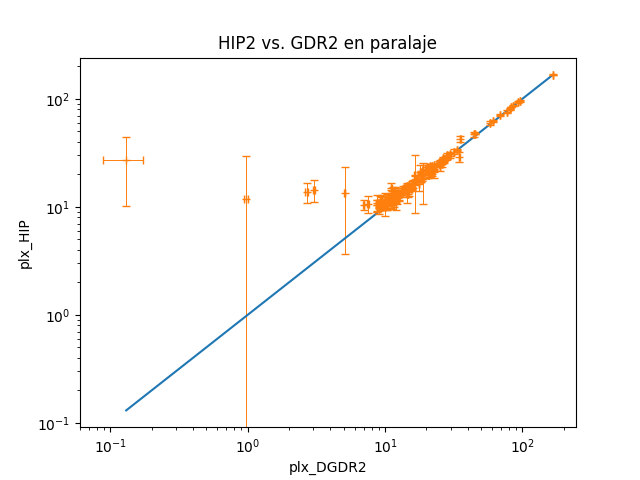

<ErrorbarContainer object of 3 artists>

In [107]:
# Parallax
show_index = False

plt.loglog()

plt.title('HIP2 vs. GDR2 en paralaje')
plt.xlabel('plx_DGDR2')
plt.ylabel('plx_HIP')

values = ['Cmp','parallax_y','Plx_y','parallax_error_y','e_Plx_y']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]


if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

"""
plt.plot(x0,x0/x0)
plt.errorbar(x0,x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='+',
             capsize=3,
             linewidth = 0.7)
"""
plt.plot(np.linspace(x1.min(),x1.max(),100),
         np.linspace(x1.min(),x1.max(),100))
plt.errorbar(x1,x2,
             x4,x3,
             fmt='+',
             capsize=3,
             linewidth = 0.7)

<IPython.core.display.Javascript object>


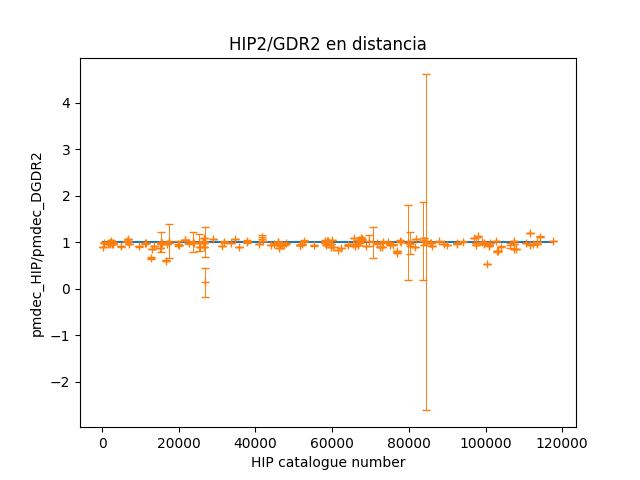

<ErrorbarContainer object of 3 artists>

In [23]:
# Distancias
show_index = False

plt.title('HIP2/GDR2 en distancia')
plt.xlabel('HIP catalogue number')
plt.ylabel('pmdec_HIP/pmdec_DGDR2')
values = ['Cmp','parallax_x','Plx_x','parallax_error_x','e_Plx_x']
x = good_pairs[values].sort_values('Cmp')
x0 = x[values[0]]
x1 = 1000./x[values[1]]
x2 = 1000./x[values[2]]
x3 = x[values[3]]*1000./x1**2
x4 = x[values[4]]*1000./x2**2

if show_index:
    for i in x.index:
        plt.text(x0[i],x2[i]/x1[i],str(x0[i]),
                 fontsize=10)

plt.plot(x0,x0/x0)
plt.errorbar(x0,x2/x1,
             np.abs((x2/x1)*(x4/x2+x3/x1)),
             fmt='+',
             capsize=3,
             linewidth = 0.7)

<IPython.core.display.Javascript object>


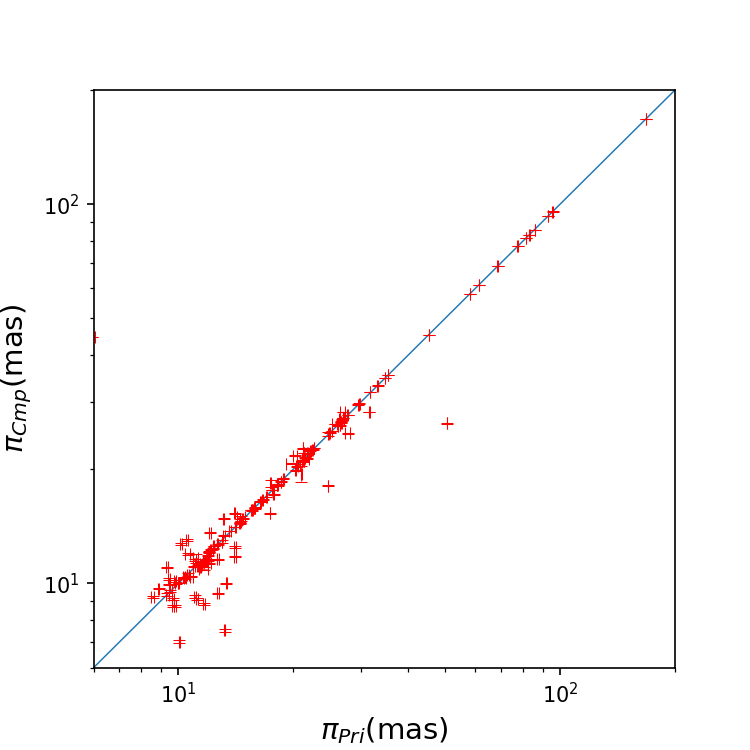

In [108]:
# Parallax pri vs cmp

fig = plt.figure(figsize=(5,5),dpi=150)
figname='fig03'

plt.xlim(6,200)
plt.ylim(6,200)

fnt=14
show_index = False
plt.loglog()

plt.xlabel(r'$\pi_{Pri}$(mas)',fontsize=fnt)
plt.ylabel(r'$\pi_{Cmp}$(mas)',fontsize=fnt)

values = ['Ind','parallax_x','parallax_y','parallax_error_x','parallax_error_y']
x = good_pairs[values].sort_values('Ind')
x0 = x[values[0]]
x1 = x[values[1]]
x2 = x[values[2]]
x3 = x[values[3]]
x4 = x[values[4]]

if show_index:
    for i in x.index:
        if np.abs(x1[i]-x2[i]) > 20.*x4[i]:
            plt.text(x1[i],x2[i],str(x0[i]),
                     fontsize=10)

plt.plot(np.linspace(x1.min(),x1.max()+100,100),
         np.linspace(x1.min(),x1.max()+100,100),
         linewidth=0.7)

plt.errorbar(x1,x2,
             x4,x3,
             fmt='r.',
             markersize=0.1,
             capsize=3,
             capthick=0.5,
             linewidth = 0.3)
plt.savefig('%s.png'%figname)
plt.savefig('%s.jpg'%figname)
plt.savefig('%s.ps'%figname)
plt.savefig('%s.pdf'%figname)

<IPython.core.display.Javascript object>


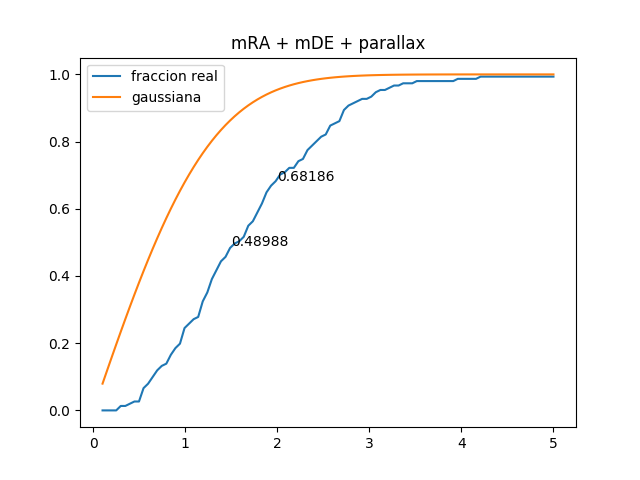

In [92]:
def fraction(gp,sig):
    x = gp.copy()
    x = x[
        (np.abs(1.-x.pmRA_y/x.pmra_y) < sig*np.abs(
              (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) &
          (np.abs(1.-x.pmDE_y/x.pmdec_y) < sig*np.abs(
              (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) &
          (np.abs(1.-x.Plx_y/x.parallax_y) < sig*np.abs(
              (x.Plx_y/x.parallax_y)*(x.e_Plx_y/x.Plx_y+x.parallax_error_y/x.parallax_y))) &
         True]
    return int(x.shape[0])

fraction(good_pairs,1.5)

plt.title('mRA + mDE + parallax')
xii = np.linspace(0.1,5,100)
yii = []
for i in xii:
    yii.append(fraction(good_pairs,i)/151.)

plt.text(1.5,0.00662*fraction(good_pairs,1.5),str(0.00662*fraction(good_pairs,1.5)))
plt.text(2,0.00662*fraction(good_pairs,2),str(0.00662*fraction(good_pairs,2)))
plt.plot(xii,yii, label='fraccion real')
plt.plot(xii,2*(stats.norm.cdf(xii)-0.5), label='gaussiana')
plt.legend()

<IPython.core.display.Javascript object>


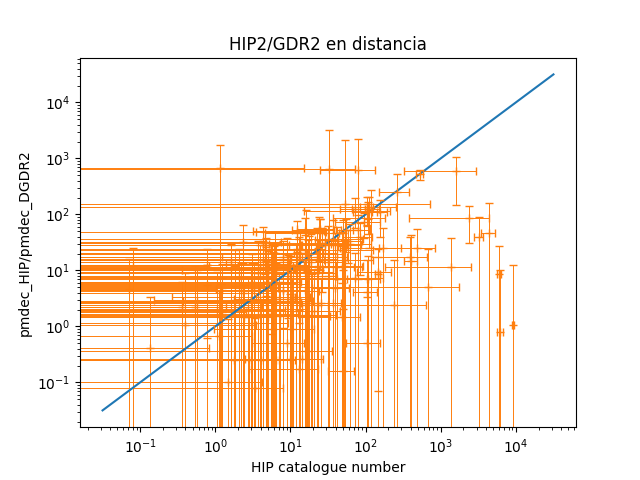

<ErrorbarContainer object of 3 artists>

In [13]:
# Distancias
show_index = False

plt.loglog()

plt.title('HIP2/GDR2 en distancia')
plt.xlabel('HIP catalogue number')
plt.ylabel('pmdec_HIP/pmdec_DGDR2')

plt.plot(np.logspace(-1.5,4.5),
         np.logspace(-1.5,4.5))

plt.errorbar((good_pairs.pmRA_y - good_pairs.pmRA_x)**2 + (good_pairs.pmDE_y - good_pairs.pmDE_x)**2,
             good_pairs.dpmb**2+good_pairs.dpml**2,
             2.*(np.abs(good_pairs.dpmb*good_pairs.e_dpmb) + np.abs(good_pairs.dpml*good_pairs.e_dpml)),
             2.*(np.abs((good_pairs.pmRA_y-good_pairs.pmRA_x)*(good_pairs.e_pmRA_x+good_pairs.e_pmRA_y)) +
                 np.abs((good_pairs.pmDE_y-good_pairs.pmDE_x)*(good_pairs.e_pmDE_x+good_pairs.e_pmDE_y))),
             fmt='+',
             capsize=3,
             linewidth = 0.7)

In [ ]:
"""
HJA = shaya[shaya.Prob > 0.9]

#Traduccion a indices de gaia dr2
shagaia = shaya.copy()
shagaia.Cmp = shagaia.Cmp.replace(hip2gdr2)
shagaia.Pri = shagaia.Pri.replace(hip2gdr2)
shagaia = shagaia[(shagaia.Cmp > 999999) & (shagaia.Pri > 999999)]

index  = h[['original_ext_source_id', 'source_id']].rename(columns={'original_ext_source_id':'hipp1','source_id': 'source_id_1'})
index2 = h[['original_ext_source_id', 'source_id']].rename(columns={'original_ext_source_id':'hipp2','source_id': 'source_id_2'})

indcmp = index.rename(columns={'hipp1':'Cmp'})
indpri = index.rename(columns={'hipp2':'Pri'})

#Dame sólo las que están en shaya
test = t.rename(columns={'source_id_1':'Pri','source_id_2': 'Cmp'})
x = pd.merge(pd.merge(test,shagaia,how='left',on='Pri'),
         index2,how='left',on='source_id_2')
x = x[~x.hipp1.isna() & ~x.hipp2.isna()].sort_values('hipp1')
x.hipp1 = x.hipp1.astype(int)
x.hipp2 = x.hipp2.astype(int)
"""

In [ ]:
test = t.rename(columns={'source_id_1':'Pri','source_id_2': 'Cmp'})
t.source_id_
x = pd.merge(pd.merge(test,index,how='left',on='source_id_1'),
         index2,how='left',on='source_id_2')
x = x[~x.hipp1.isna() & ~x.hipp2.isna()].sort_values('hipp1')
x.hipp1 = x.hipp1.astype(int)
x.hipp2 = x.hipp2.astype(int)

#To convert float column to int

In [13]:
# G*Msol = 0.3035 pc km^2/s^2
r=(np.pi/180.)*(1./3600.)*7000
0.3035**2*r**(-.5)

0.5000125873177167

In [9]:
rjacobi = 1.7 #pc (M1+M2/2Msol)^1/3
Omega_g_rj = 0.05 #km/s (M1+M2/2Msol)^1/3
#Coordenadas en papel milimétrico
tremaine=np.array([
    [ 35,   39,   53, 56,   67,77,  81,  85,  90,97,  100,  105,  110,  115,118,127,135,142,150,160,172,180,190,198,206,213,220],
    [135,131.2,117.9,115,104.5,95,91.2,87.4,82.6,76, 73.1, 68.4, 63.6, 58.8, 56,52,57,68,69,70,72,74,77,80,83,85,85]])

#Conversión de la escala del papel a valores
DIST_trem = 7./203*tremaine[0]-4.5  #7 dex(rp/rj)/203mm
RMS_trem = 3./167*tremaine[1]-1. # 3 dex(rms V en rJ*omegaG)/167mm

f1 = inp.interp1d(DIST_trem,RMS_trem)
f2 = inp.interp1d(DIST_trem,RMS_trem,kind='cubic')
xspan = np.linspace(DIST_trem.min(),DIST_trem.max(),100)


plt.loglog()

plt.plot(rjacobi*10**(DIST_trem),Omega_g_rj*10**(RMS_trem),'x',
    #xspan,f1(xspan),'-g',
    rjacobi*10**(xspan),Omega_g_rj*10**(f2(xspan)),'--r')


#plt.plot(DIST_trem,RMS_trem,'+')

## Construyendo el histrograma:

h = []
c = np.pi/(180*3600*1000)

for i in range(10):
    h.append(good_pairs[(good_pairs.proy_sep_GDR2 > -2.5 + 0.4*i) &
                          (good_pairs.proy_sep_GDR2 > -2.5 + 0.4*(i+1))])

((c*1000*(good_pairs.pmra_y/good_pairs.parallax_y - good_pairs.pmra_x/good_pairs.parallax_x))**2).mean()**.5


1.1607694400063274e-05

In [202]:
# cRITERION selection
#x = good_pairs.copy()
#x = good_stars.copy()
sig = 3.0

x = seleccion(good_pairs,sigma=3.,rvel=3.)

#turd = x[(x.proy_sep_GDR2 > 1.99) &
#  (x.proy_sep_GDR2 < 10.)][['Ind','pmra_x','pmra_y','pmdec_x','pmdec_y','parallax_x','parallax_y']]
#vel_tan_diff(turd.pmra_x,1E-30,1000./turd.parallax_x,
#             turd.pmra_y,1E-30,1000./turd.parallax_y)
#1000/turd.parallax_y

145     55.232279
322     44.067145
362     35.352602
422     90.724416
443    100.649421
498     89.593808
545     87.441822
571    114.852206
587     99.746437
613    107.150797
621     86.755326
796     87.808348
806    108.377842
812     86.437701
830     83.820832
Name: parallax_y, dtype: float64

In [7]:
# Aplicando la corrección esférica

x = seleccion(good_pairs,sigma=3.,rvel=3.)
x = x[x.Ind != 128]
#pc*mas/yr to km/s
c = (np.pi/(180*3600*1000))*(3.086E13)/(365*24*3600.)

n_bins = 5
rmin   = -2.5
rmax   = 1.
step   = (rmax-rmin)/n_bins

rms_ra=[]
rms_ra_error=[]
rms_dec=[]
rms_dec_error=[]
rms_tan=[]
rms_tan_error=[]
rms_rad=[]
rms_rad_error=[]
sep=[]
samp=[]
for i in range(n_bins):
    
    _temp = x[(x.proy_sep_GDR2 > 10**(rmin+i*step)) &
           (x.proy_sep_GDR2 < 10**(rmin+(i+1)*step))]
    print('Intervalo %f %f\n'%(10**(rmin+i*step),10**(rmin+(i+1)*step)))
#CORRECION ESFERICA SOBRE LA PRIMARIA    
#    pmrax = _temp.pmra_x
    pmrax = _temp.pmra_x - _temp.pmra_corr
#    pmdex = _temp.pmdec_x
    pmdex = _temp.pmdec_x - _temp.pmde_corr
    pmray = _temp.pmra_y
    pmdey = _temp.pmdec_y
    distx = 1000./_temp.parallax_x
    disty = 1000./_temp.parallax_y
#    rvelx = _temp.radial_velocity_x
    rvelx = _temp.radial_velocity_x - _temp.rvel_corr    
    rvely = _temp.radial_velocity_y
    
    pmrax_err = _temp.pmra_error_x
    pmdex_err = _temp.pmdec_error_x
    pmray_err = _temp.pmra_error_y
    pmdey_err = _temp.pmdec_error_y
    distx_err = distx*_temp.parallax_error_x/_temp.parallax_x
    disty_err = disty*_temp.parallax_error_y/_temp.parallax_y
    rvelx_err = _temp.radial_velocity_error_x
    rvely_err = _temp.radial_velocity_error_y
    
    
    
    rmsa = np.sqrt((vel_tan_diff(pmrax,0.,distx,
                                 pmray,0.,disty)**2).mean())
    rmsa_error = (np.abs(
        vel_tan_diff(pmrax,0.,distx,pmray,0.,disty)*
        vel_tan_diff_err(pmrax,pmrax_err,1E-20,1E-30,distx,distx_err,
                         pmray,pmray_err,1E-20,1E-30,disty,disty_err))).mean()/rmsa
#    rmsa_error = c**2*(np.abs((disty*pmray-distx*pmrax)*(
#                                 disty_err*pmray+
#                                 disty*pmray_err+
#                                 distx_err*pmrax+
#                                 distx*pmrax_err)).mean())/rmsa

    rmsd = np.sqrt((vel_tan_diff(0.,pmdex,distx,
                                 0.,pmdey,disty)**2).mean())
    rmsd_error = (np.abs(
        vel_tan_diff(0.,pmdex,distx,0.,pmdey,disty)*
        vel_tan_diff_err(1E-20,1E-30,pmdex,pmdex_err,distx,distx_err,
                         1E-20,1E-30,pmdey,pmdey_err,disty,disty_err))).mean()/rmsd

    rmst = np.sqrt(rmsa**2+rmsd**2)
        
    rmst_error = (np.abs(
        vel_tan_diff(pmrax,pmdex,distx,pmray,pmdey,disty)*
        vel_tan_diff_err(pmrax,pmrax_err,pmdex,pmdex_err,distx,distx_err,
                         pmray,pmray_err,pmdey,pmdey_err,disty,disty_err))).mean()/rmst
    
    rmsr = np.sqrt(((rvely-rvelx)**2).mean())
    rmsr_error = np.abs((rvely-rvelx)*(rvelx_err+rvely_err)).mean()/rmsr

# Agregar error poissoniano:
    rmsa_error = np.sqrt(_temp.shape[0])*rmsa_error
    rmsd_error = np.sqrt(_temp.shape[0])*rmsd_error
    
    rms_ra.append(rmsa)
    rms_ra_error.append(rmsa_error)
    rms_dec.append(rmsd)
    rms_dec_error.append(rmsd_error)
    rms_tan.append(rmst)
    rms_tan_error.append(rmst_error)
    rms_rad.append(rmsr)
    rms_rad_error.append(rmsr_error)
    sep.append(rmin+(i+0.5)*step)
    samp.append(_temp.shape[0])
    
    print(rmsa, rmsa_error)
    print(rmsd, rmsd_error)
#    print(rmst, rmst_error)
    print(step)
    print('x')
print(sep)

Intervalo 0.003162 0.015849

0.8612121552208856 0.45658421646300995
0.5226728833651964 0.3162848238665518
0.7
x
Intervalo 0.015849 0.079433

0.44390816277527423 0.370240416468099
0.5671111958398773 0.3646071444860777
0.7
x
Intervalo 0.079433 0.398107

0.6091086649082845 0.6116115004269265
0.8714051560949468 0.3170301579414769
0.7
x
Intervalo 0.398107 1.995262

1.374540619129756 0.4129726664940292
1.3154858930050795 0.2255433603945224
0.7
x
Intervalo 1.995262 10.000000

1.2706949413439441 0.3788531787076059
1.557727344582223 0.292794632615187
0.7
x
[-2.15, -1.4500000000000002, -0.75, -0.050000000000000266, 0.6499999999999999]


In [18]:
x = seleccion(good_pairs,sigma=3.,rvel=3.)
x = x[x.Ind != 128]
x[~x.radial_velocity_x.isna() | ~x.radial_velocity_y.isna()].describe()

Ind      Pri_GDR2      Cmp_GDR2            Pri            Cmp  \
count   71.000000  7.100000e+01  7.100000e+01      71.000000      71.000000   
mean   392.873239  3.877108e+18  3.876511e+18   55625.957746   55603.549296   
std    229.325030  2.010073e+18  2.015967e+18   34566.195203   34575.522583   
min     16.000000  1.058490e+16  1.060857e+16     493.000000     495.000000   
25%    212.500000  2.327196e+18  2.327091e+18   22698.500000   22705.000000   
50%    392.000000  4.236276e+18  4.235896e+18   58067.000000   58490.000000   
75%    570.000000  5.418410e+18  5.401828e+18   87496.500000   87424.500000   
max    793.000000  6.879765e+18  6.879662e+18  114131.000000  114112.000000   

             GLON       GLAT       Vmag  f_Vmag          pml          pmb  \
count   71.000000  71.000000  71.000000     0.0    71.000000    71.000000   
mean   203.667606  -7.501408   8.711690     NaN   -77.919718    -3.761972   
std    106.918932  40.503010   1.163377     NaN   284.098418   195.164045   
min     15.400000 -82.200000   5.530000     NaN -1444.200000 -1047.000000   
25%    108.250000 -37.450000   8.020000     NaN  -117.500000   -70.750000   
50%    224.700000 -13.100000   8.480000     NaN   -35.500000    -8.000000   
75%    293.700000  15.750000   9.170000     NaN    16.500000    44.350000   
max    358.200000  85.200000  11.390000     NaN   449.800000   638.900000   

            dpml     e_dpml       dpmb     e_dpmb        Dis      e_Dis  \
count  71.000000  71.000000  71.000000  71.000000  71.000000  71.000000   
mean   -0.329577   3.270423  -0.350704   2.798592  54.673239   4.391549   
std     5.359941   5.564361   4.238055   4.534802  26.902188   4.852650   
min   -24.300000   1.200000 -19.800000   1.300000  10.600000   0.000000   
25%    -1.950000   1.600000  -1.300000   1.600000  35.650000   1.250000   
50%    -0.100000   1.900000   0.200000   1.900000  51.200000   2.400000   
75%     1.350000   2.400000   1.550000   2.450000  77.250000   6.700000   
max    23.500000  33.100000  15.900000  39.100000  99.900000  28.300000   

            Rvel     dRVel    e_dRVel       Mass         dR       Prob  \
count  47.000000  42.00000  42.000000  71.000000  71.000000  71.000000   
mean    6.121277   0.92619   1.645238   0.983944   0.628906   0.993521   
std    24.309454   5.55698   2.768922   0.617285   1.399046   0.016742   
min   -44.700000 -10.10000   0.100000   0.300000   0.003300   0.920000   
25%    -9.800000  -0.27500   0.300000   0.830000   0.013400   1.000000   
50%     5.600000  -0.10000   0.400000   0.930000   0.039200   1.000000   
75%    19.800000   0.40000   2.075000   1.105000   0.275600   1.000000   
max    90.800000  28.40000  14.100000   5.670000   7.167900   1.000000   

          RAdeg_y    DEdeg_y  e_RAdeg_y  e_DEdeg_y      Plx_y       pmRA_y  \
count   71.000000  71.000000  71.000000  71.000000  71.000000    71.000000   
mean   170.796337 -12.297857   1.574789   1.202113  26.805634    -0.457324   
std    104.394268  41.464220   3.077860   1.894509  21.670644   263.660087   
min      1.481514 -76.023924   0.480000   0.420000   9.890000  -920.080000   
25%     73.171576 -51.255913   0.685000   0.665000  12.945000  -104.135000   
50%    179.926540  -5.897484   1.030000   0.800000  19.520000     0.600000   
75%    267.788339  17.700179   1.320000   1.060000  28.025000    72.210000   
max    346.663324  81.138947  24.330000  15.130000  94.590000  1337.570000   

            pmDE_y    e_Plx_y   e_pmRA_y   e_pmDE_y    Hpmag_y  e_Hpmag_y  \
count    71.000000  71.000000  71.000000  71.000000  71.000000  71.000000   
mean    -47.218873   1.304225   1.311972   1.047183   8.826725   0.003111   
std     230.592389   1.283028   1.102901   0.685953   1.151973   0.004228   
min   -1129.600000   0.200000   0.210000   0.210000   5.640500   0.000500   
25%     -63.580000   0.750000   0.690000   0.645000   8.142050   0.001500   
50%     -13.380000   1.030000   1.020000   0.850000   8.605900   0.001900   
75%      23.520000   1.

In [36]:
#PRUEBA: NO SÉ QUE HAGO AQUI
# Aplicando la corrección esférica

x = seleccion(good_pairs,sigma=3.,rvel=3.)
x = x[x.Ind != 128]
x = x[~x.radial_velocity_x.isna() | x.radial_velocity_y.isna()]
#pc*mas/yr to km/s
c = (np.pi/(180*3600*1000))*(3.086E13)/(365*24*3600.)

n_bins = 5
rmin   = -2.5
rmax   = 1.
step   = (rmax-rmin)/n_bins

rms_ra=[]
rms_ra_error=[]
rms_dec=[]
rms_dec_error=[]
rms_tan=[]
rms_tan_error=[]
rms_rad=[]
rms_rad_error=[]
sep=[]
samp=[]
for i in range(n_bins):
    
    _temp = x[(x.proy_sep_GDR2 > 10**(rmin+i*step)) &
           (x.proy_sep_GDR2 < 10**(rmin+(i+1)*step))]
    print('Intervalo %f %f\n'%(10**(rmin+i*step),10**(rmin+(i+1)*step)))

    #CORRECION ESFERICA SOBRE LA PRIMARIA    
#    pmrax = _temp.pmra_x
    pmrax = _temp.pmra_x - _temp.pmra_corr
#    pmdex = _temp.pmdec_x
    pmdex = _temp.pmdec_x - _temp.pmde_corr
    pmray = _temp.pmra_y
    pmdey = _temp.pmdec_y
    distx = 1000./_temp.parallax_x
    disty = 1000./_temp.parallax_y
#    rvelx = _temp.radial_velocity_x
    rvelx = _temp.radial_velocity_x - _temp.rvel_corr
    rvely = _temp.radial_velocity_y
    
    pmrax_err = _temp.pmra_error_x
    pmdex_err = _temp.pmdec_error_x
    pmray_err = _temp.pmra_error_y
    pmdey_err = _temp.pmdec_error_y
    distx_err = distx*_temp.parallax_error_x/_temp.parallax_x
    disty_err = disty*_temp.parallax_error_y/_temp.parallax_y
    rvelx_err = _temp.radial_velocity_error_x
    rvely_err = _temp.radial_velocity_error_y
    
    
    
    rmsa = np.sqrt((vel_tan_diff(pmrax,0.,distx,
                                 pmray,0.,disty)**2).mean())
    rmsa_error = (np.abs(
        vel_tan_diff(pmrax,0.,distx,pmray,0.,disty)*
        vel_tan_diff_err(pmrax,pmrax_err,1E-20,1E-30,distx,distx_err,
                         pmray,pmray_err,1E-20,1E-30,disty,disty_err))).mean()/rmsa
#    rmsa_error = c**2*(np.abs((disty*pmray-distx*pmrax)*(
#                                 disty_err*pmray+
#                                 disty*pmray_err+
#                                 distx_err*pmrax+
#                                 distx*pmrax_err)).mean())/rmsa

    rmsd = np.sqrt((vel_tan_diff(0.,pmdex,distx,
                                 0.,pmdey,disty)**2).mean())
    rmsd_error = (np.abs(
        vel_tan_diff(0.,pmdex,distx,0.,pmdey,disty)*
        vel_tan_diff_err(1E-20,1E-30,pmdex,pmdex_err,distx,distx_err,
                         1E-20,1E-30,pmdey,pmdey_err,disty,disty_err))).mean()/rmsd

    rmst = np.sqrt(rmsa**2+rmsd**2)
        
    rmst_error = (np.abs(
        vel_tan_diff(pmrax,pmdex,distx,pmray,pmdey,disty)*
        vel_tan_diff_err(pmrax,pmrax_err,pmdex,pmdex_err,distx,distx_err,
                         pmray,pmray_err,pmdey,pmdey_err,disty,disty_err))).mean()/rmst
    
    rmsr = np.sqrt(((rvely-rvelx)**2).mean())
    rmsr_error = np.abs((rvely-rvelx)*(rvelx_err+rvely_err)).mean()/rmsr

# Agregar error poissoniano:
    rmsa_error = np.sqrt(_temp.shape[0])*rmsa_error
    rmsd_error = np.sqrt(_temp.shape[0])*rmsd_error
    
    rms_ra.append(rmsa)
    rms_ra_error.append(rmsa_error)
    rms_dec.append(rmsd)
    rms_dec_error.append(rmsd_error)
    rms_tan.append(rmst)
    rms_tan_error.append(rmst_error)
    rms_rad.append(rmsr)
    rms_rad_error.append(rmsr_error)
    sep.append(rmin+(i+0.5)*step)
    samp.append(_temp.shape[0])
    
    print(rmsa, rmsa_error)
    print(rmsd, rmsd_error)
#    print(rmst, rmst_error)
    print(step)
    print('x')
print(sep)

Intervalo 0.003162 0.015849

0.5302689654303396 0.37977834486203554
0.3286433910248872 0.3407763837684212
0.7
x
Intervalo 0.015849 0.079433

0.2964418414621745 0.37793951059482406
0.3243482629906849 0.39381008729088285
0.7
x
Intervalo 0.079433 0.398107

0.623368900706125 0.6096989554206389
0.8981856912835354 0.31677909636566454
0.7
x
Intervalo 0.398107 1.995262

1.3098017039548677 0.424548092463589
1.3784529383239412 0.2372473770040126
0.7
x
Intervalo 1.995262 10.000000

1.5657389051864263 0.11377340663471773
2.907563793825147 0.21427577544539095
0.7
x
[-2.15, -1.4500000000000002, -0.75, -0.050000000000000266, 0.6499999999999999]


## Histogramas

<IPython.core.display.Javascript object>


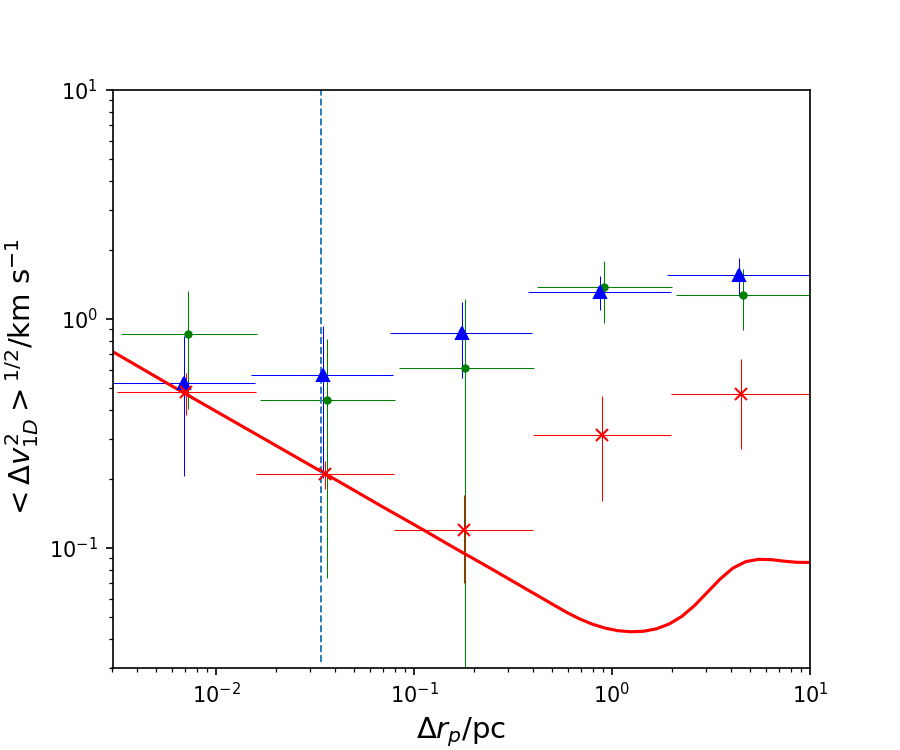

In [21]:
#RMS
save     = False
n_members= False
fig = plt.figure(figsize=(6,5),dpi=150)
#fig.suptitle('Con correccion+')
#figname='fig04'
figname='fig04'

fnt=14

plt.loglog()
plt.xlabel(r'$\Delta r_{p}$/pc',fontsize=fnt)
plt.ylabel(r'$<\Delta v_{1D}^2>^{1/2}$/km s$^{-1}$',fontsize=fnt)

plt.xlim(0.3E-2,1E1)
plt.ylim(0.03,10.)
#plt.ylim(0.05,.6)

xspan = np.linspace(DIST_trem.min(),DIST_trem.max(),100)
#plt.xlim((10**(-3),10**(1.5)))

plt.plot(
    #rjacobi*10**(DIST_trem),Omega_g_rj*10**(RMS_trem),'x'
    #xspan,f1(xspan),'-g',
    rjacobi*10**(xspan),Omega_g_rj*10**(f2(xspan)),'r')

# Integrantes del bin
"""
for i in range(len(sep)):
    plt.text(10**(sep[i]),1.1*rms_ra[i],str(samp[i]))


"""
plt.errorbar(10**(np.array(sep)+0.01),rms_ra,
             rms_ra_error,
             (10**(np.array(sep)) - 10**(np.array(sep)-0.5*step),
              10**(np.array(sep)+0.5*step) - 10**(np.array(sep))),
             fmt='g.',
             linewidth=0.5,
            label=r'$<\Delta v_\alpha^2>^{1/2}$')

plt.errorbar(10**(np.array(sep)-0.01),rms_dec,rms_dec_error,
             (10**(np.array(sep)) - 10**(np.array(sep)-0.5*step),
              10**(np.array(sep)+0.5*step) - 10**(np.array(sep))),             
             fmt='b^',
             linewidth=0.5,
             label=r'$<\Delta v_\delta^2>^{1/2}$')

banik = np.array([.480,.210,.120,.310,.470])
banik_err = np.array([.100,.030,.050,.150,.200])

plt.errorbar(10**(np.array(sep)),banik,banik_err,
             (10**(np.array(sep)) - 10**(np.array(sep)-0.5*step),
              10**(np.array(sep)+0.5*step) - 10**(np.array(sep))),             
             fmt='rx',
             linewidth=0.5,
             label='Banik')

if n_members:
    for i in range(len(sep)):
        plt.text(10**(sep[i]),1.1*rms_dec[i],str(samp[i]))

#for i in range(len(sep)):
#    plt.text(10**(sep[i]),1.1*rms_tan[i],str(samp[i]))
#plt.errorbar(10**(np.array(sep)),rms_tan,rms_tan_error,
#             (10**(np.array(sep)) - 10**(np.array(sep)-0.5*step),
#              10**(np.array(sep)+0.5*step) - 10**(np.array(sep))),
#             fmt='^',
#             linewidth=0.5,
#            label=r'$<\Delta v_\alpha^2 + \Delta v_\delta^2>^{1/2}$')

#plt.errorbar(10**(np.array(sep)),rms_rad,rms_rad_error,
#             (10**(np.array(sep)) - 10**(np.array(sep)-0.5*step),
#              10**(np.array(sep)+0.5*step) - 10**(np.array(sep))),
#             fmt='*',
#             linewidth=0.5,
#            label=r'$<\Delta v_r^2>^{1/2}$')

#plt.plot(10**xspan,0.001*(1.2E-10*3.086E16)**0.5*(10**xspan)**0.5,
#         '--')
#plt.text(2,6,r'$(\Delta v_{1D})^2/ \Delta r_p=a_0$',
#        rotation=30)

plt.axvline(x=0.034, ymin=0.009, ymax=10,
             linestyle='--',linewidth=0.9)
#plt.legend()
if save:
    plt.savefig('%s.png'%figname)
    plt.savefig('%s.jpg'%figname)
    plt.savefig('%s.ps'%figname)
    plt.savefig('%s.pdf'%figname)

<IPython.core.display.Javascript object>


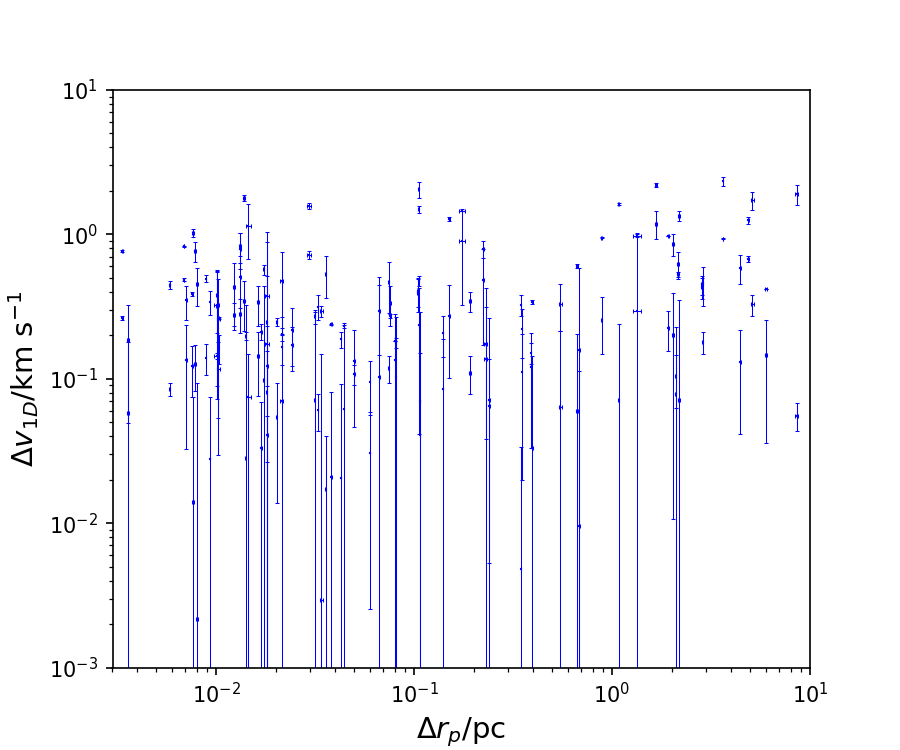

In [11]:
#Figure

fig = plt.figure(figsize=(6,5),dpi=150)
figname='fig05'
fnt=14

plt.loglog()
#plt.semilogx()
plt.xlabel(r'$\Delta r_{p}$/pc',fontsize=fnt)
plt.ylabel(r'$\Delta v_{1D}$/km s$^{-1}$',fontsize=fnt)
#plt.suptitle('Sin correccion')
#plt.title('Binarias, sin seleccionar')

plt.xlim(0.3E-2,1E1)
plt.ylim(0.001,10.)

#Todas
x = seleccion(good_pairs,sigma=3.,rvel=3.)

cp=1
thi=0.5
plt.errorbar(x.proy_sep_GDR2,
########################CON CORRECION             
#             vel_tan_diff(x.pmra_x,0.,500.*(1./ x.parallax_x + 1./ x.parallax_y),
             vel_tan_diff(x.pmra_x-x.pmra_corr ,0.,500.*(1./ x.parallax_x + 1./ x.parallax_y),             
                          x.pmra_y,0.,500.*(1./ x.parallax_x + 1./ x.parallax_y)),
#             vel_tan_diff_err(x.pmra_x,x.pmra_error_x,1E-20,1E-30,
             vel_tan_diff_err(x.pmra_x-x.pmra_corr,x.pmra_error_x,1E-20,1E-30,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2)),
                              x.pmra_y,x.pmra_error_y,1E-20,1E-30,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2))),
             x.proy_sep_error_GDR2,
             fmt='+b',
             linewidth=thi,
             markersize=1.0,
             capsize=cp,
             capthick=thi,
             label=r'$<\Delta v_\delta^2>^{1/2}$')

plt.errorbar(x.proy_sep_GDR2,
########################CON CORRECION                          
             vel_tan_diff(0.,x.pmdec_x,500.*(1./ x.parallax_x + 1./ x.parallax_y),
#             vel_tan_diff(0.,x.pmdec_x-x.pmde_corr,500.*(1./ x.parallax_x + 1./ x.parallax_y),                          
                          0.,x.pmdec_y,500.*(1./ x.parallax_x + 1./ x.parallax_y)),
             vel_tan_diff_err(1E-20,1E-30,x.pmdec_x,x.pmdec_error_x,
#             vel_tan_diff_err(1E-20,1E-30,x.pmdec_x-x.pmde_corr,x.pmdec_error_x,                              
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2)),
                              1E-20,1E-30,x.pmdec_y,x.pmdec_error_y,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2))),
             x.proy_sep_error_GDR2,
             fmt='+b',
             linewidth=thi,
             markersize=1.0,
             capsize=cp,
             capthick=thi,
             label=r'$<\Delta v_\delta^2>^{1/2}$')

"""
# Las que no tienen velocidad radial
x = seleccion(good_pairs,sigma=3.,rvel=3.)
x = x[x.radial_velocity_x.isna() | x.radial_velocity_y.isna()]

plt.errorbar(x.proy_sep_GDR2,
             vel_tan_diff(x.pmra_x,0.,500.*(1./ x.parallax_x + 1./ x.parallax_y),
                          x.pmra_y,0.,500.*(1./ x.parallax_x + 1./ x.parallax_y)),
             vel_tan_diff_err(x.pmra_x,x.pmra_error_x,1E-20,1E-30,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2)),
                              x.pmra_y,x.pmra_error_y,1E-20,1E-30,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2))),
             x.proy_sep_error_GDR2,
             fmt='+g',
             linewidth=thi,
             markersize=1.0,
             capsize=cp,
             capthick=thi,
             label=r'$<\Delta v_\delta^2>^{1/2}$')

plt.errorbar(x.proy_sep_GDR2,
             vel_tan_diff(0.,x.pmdec_x,500.*(1./ x.parallax_x + 1./ x.parallax_y),
                          0.,x.pmdec_y,500.*(1./ x.parallax_x + 1./ x.parallax_y)),
             vel_tan_diff_err(1E-20,1E-30,x.pmdec_x,x.pmdec_error_x,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2)),
                              1E-20,1E-30,x.pmdec_y,x.pmdec_error_y,
                              500.*(1./ x.parallax_x + 1./ x.parallax_y), 500.*(x.parallax_error_x*x.parallax_x**(-2) + x.parallax_error_y*x.parallax_y**(-2))),
             x.proy_sep_error_GDR2,
             fmt='+b',
             linewidth=thi,
             markersize=1.0,
             capsize=cp,
             capthick=thi,
             label=r'$<\Delta v_\delta^2>^{1/2}$')
"""

"""
for i in x.index:
#    if (np.abs(x.radial_velocity_y[i]-x.radial_velocity_x[i]) >1.):
    if True:
    
        plt.text(x.proy_sep_GDR2[i],
                 vel_tan_diff(x.pmra_x[i],0.,500.*(1./ x.parallax_x[i] + 1./ x.parallax_y[i]),
                              x.pmra_y[i],0.,500.*(1./ x.parallax_x[i] + 1./ x.parallax_y[i])),                 
                 '%.2f'%(np.abs(x.radial_velocity_y[i]-x.radial_velocity_x[i])),
                 fontsize=4)
        plt.text(x.proy_sep_GDR2[i],
                 vel_tan_diff(0.,x.pmdec_x[i],500.*(1./ x.parallax_x[i] + 1./ x.parallax_y[i]),
                              0.,x.pmdec_y[i],500.*(1./ x.parallax_x[i] + 1./ x.parallax_y[i])),
                 '%.2f'%(np.abs(x.radial_velocity_y[i]-x.radial_velocity_x[i])),
                 fontsize=4)
"""                 
0
#plt.axvline(x=0.034, ymin=0.009, ymax=10,
#             linestyle='--',linewidth=0.9)
        
#plt.legend()
plt.savefig('%s.png'%figname)
plt.savefig('%s.jpg'%figname)
plt.savefig('%s.ps'%figname)
plt.savefig('%s.pdf'%figname)

In [68]:
good_pairs.shape
seleccion(good_pairs).shape

(81, 123)

<IPython.core.display.Javascript object>


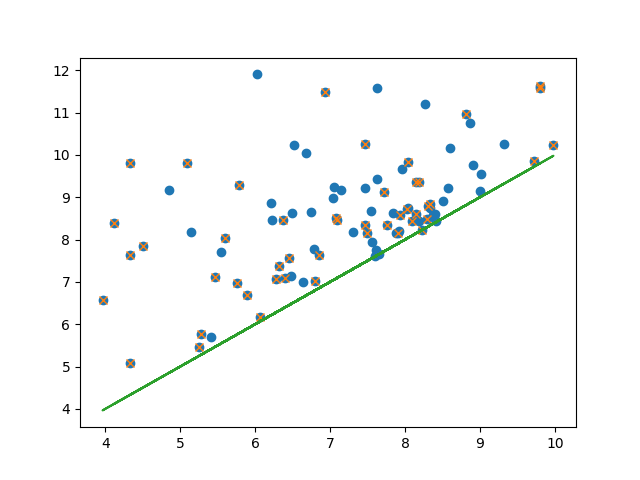

In [26]:
x = seleccion(good_pairs,sigma=3.,rvel=3.)
xx = x[x.radial_velocity_x.isna() | x.radial_velocity_y.isna()]
plt.plot(x.phot_bp_mean_mag_x,x.phot_bp_mean_mag_y,'o',
         xx.phot_bp_mean_mag_x,xx.phot_bp_mean_mag_y,'x')
plt.plot(x.phot_bp_mean_mag_x,x.phot_bp_mean_mag_x)

In [24]:
x = seleccion(good_pairs,sigma=3.,rvel=3.)
xx = x[x.radial_velocity_x.isna() | x.radial_velocity_y.isna()]

plt.plot(x.phot_g_mean_mag_x,x.phot_g_mean_mag_y,'o',
         xx.phot_g_mean_mag_x,xx.phot_g_mean_mag_y,'x')
plt.plot(x.phot_g_mean_mag_x,x.phot_g_mean_mag_x)

<IPython.core.display.Javascript object>

In [20]:
rads = good_pairs[np.abs(good_pairs.radial_velocity_x-good_pairs.radial_velocity_y) > 3.]

In [64]:
sigma = 3.
par=.6
rvel = 3.
x = seleccion(good_pairs,sigma=3.,rvel=1E10)
"""
x[(np.abs(1.-x.pmRA_y/x.pmra_y) < sigma*np.abs(
                 (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) &
             (np.abs(1.-x.pmDE_y/x.pmdec_y) < sigma*np.abs(
                 (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) &
                 (np.abs(1.-x.pmRA_x/x.pmra_x) < sigma*np.abs(
                 (x.pmRA_x/x.pmra_x)*(x.e_pmRA_x/x.pmRA_x+x.pmra_error_x/x.pmra_x))) &
             (np.abs(1.-x.pmDE_y/x.pmdec_y) < sigma*np.abs(
                 (x.pmDE_x/x.pmdec_x)*(x.e_pmDE_x/x.pmDE_x+x.pmdec_error_x/x.pmdec_x))) &
             (x.parallax_y > par*x.parallax_x) &
             (x.parallax_y < (1.+par)*x.parallax_x) &
             ((np.abs(x.radial_velocity_x-x.radial_velocity_y) < rvel) | (x.radial_velocity_x.isna()) | (x.radial_velocity_y.isna())) &
           True].shape
"""           

'\nx[(np.abs(1.-x.pmRA_y/x.pmra_y) < sigma*np.abs(\n                 (x.pmRA_y/x.pmra_y)*(x.e_pmRA_y/x.pmRA_y+x.pmra_error_y/x.pmra_y))) &\n             (np.abs(1.-x.pmDE_y/x.pmdec_y) < sigma*np.abs(\n                 (x.pmDE_y/x.pmdec_y)*(x.e_pmDE_y/x.pmDE_y+x.pmdec_error_y/x.pmdec_y))) &\n                 (np.abs(1.-x.pmRA_x/x.pmra_x) < sigma*np.abs(\n                 (x.pmRA_x/x.pmra_x)*(x.e_pmRA_x/x.pmRA_x+x.pmra_error_x/x.pmra_x))) &\n             (np.abs(1.-x.pmDE_y/x.pmdec_y) < sigma*np.abs(\n                 (x.pmDE_x/x.pmdec_x)*(x.e_pmDE_x/x.pmDE_x+x.pmdec_error_x/x.pmdec_x))) &\n             (x.parallax_y > par*x.parallax_x) &\n             (x.parallax_y < (1.+par)*x.parallax_x) &\n             ((np.abs(x.radial_velocity_x-x.radial_velocity_y) < rvel) | (x.radial_velocity_x.isna()) | (x.radial_velocity_y.isna())) &\n           True].shape\n'

In [67]:
y = x[(np.abs(x.radial_velocity_x-x.radial_velocity_y) > 3.)]

In [67]:
seleccion(good_pairs)

(83, 113)